# Hard-10 Benchmark Visualization

Interactive visualization of the 10 hardest SGQA problems to debug temporal reasoning failures.

**Visual Elements:**
- Hand usage (H1/H2/both) - colored indicators
- Temporal boundaries - episode markers
- Ground truth object - gold highlighting

In [1]:
# Cell 1: Imports & Setup
import sys
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from IPython.display import display, HTML, Markdown

# Add paths for imports
ROOT_DIR = Path('/home/jtu9/sgg/tsg-bench')
sys.path.insert(0, str(ROOT_DIR))

# Import from existing visualization package
from visualization import (
    draw_scene_graph,
    draw_context_graphs,
    NODE_COLORS,
    format_graph_as_text,
)

# Load Hard-10 data
HARD10_PATH = ROOT_DIR / 'anygran' / 'benchmarks' / 'hard_10' / 'sgqa_hard_10.json'
with open(HARD10_PATH, 'r') as f:
    hard10_data = json.load(f)

cases = hard10_data['cases']
print(f"Loaded {len(cases)} hard cases")
print(f"Error categories: {set(c.get('error_category', 'unknown') for c in cases)}")

Loaded 10 hard cases
Error categories: {'temporal_ordering', 'both_hands', 'multi_step', 'concurrent_state'}


In [2]:
# Cell 2: Helper Functions

# Color scheme for hand usage
HAND_COLORS = {
    'hand1': '#4A90D9',      # Blue
    'hand2': '#D94A4A',      # Red
    'both': '#9B59B6',       # Purple
    'none': '#CCCCCC',       # Gray
}

GT_COLOR = '#FFD700'  # Gold for ground truth
GT_BORDER = '#B8860B'  # Dark gold border

def extract_action_info(graph_triplets):
    """Extract verb, object, and hand usage from a single action graph."""
    info = {
        'verb': None,
        'object': None,
        'hands': [],
        'is_both_hands': False,
        'locations': [],
    }
    
    for triplet in graph_triplets:
        if len(triplet) < 3:
            continue
        subj, rel, obj = triplet[0], triplet[1], triplet[2]
        
        if rel == 'verb':
            info['verb'] = obj
        elif rel == 'dobj':
            info['object'] = obj
        elif rel == 'with' and obj.startswith('hand'):
            info['hands'].append(obj)
        elif rel in ['from', 'to', 'on', 'onto', 'into', 'in']:
            info['locations'].append((rel, obj))
    
    info['is_both_hands'] = len(info['hands']) == 2
    return info


def get_hand_color(hands):
    """Get color based on hand usage."""
    if len(hands) == 2:
        return HAND_COLORS['both']
    elif 'hand1' in hands:
        return HAND_COLORS['hand1']
    elif 'hand2' in hands:
        return HAND_COLORS['hand2']
    return HAND_COLORS['none']


def get_hand_label(hands):
    """Get label for hand usage."""
    if len(hands) == 2:
        return 'H1+H2'
    elif 'hand1' in hands:
        return 'H1'
    elif 'hand2' in hands:
        return 'H2'
    return '-'


def create_timeline_figure(case, figsize=(18, 5)):
    """Create horizontal timeline with hand-usage coloring and GT highlighting."""
    context_graphs = case['context_graphs']
    ground_truth = case['ground_truth'].lower()
    n_frames = len(context_graphs)
    
    # Extract info for each frame
    timeline = [extract_action_info(g) for g in context_graphs]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot parameters
    bar_height = 0.6
    y_verb = 2
    y_obj = 1
    y_hand = 0
    
    # Find frames where ground truth appears
    gt_frames = []
    for i, info in enumerate(timeline):
        if info['object'] and ground_truth in info['object'].lower():
            gt_frames.append(i)
    
    # Plot each frame
    for i, info in enumerate(timeline):
        x = i
        hand_color = get_hand_color(info['hands'])
        is_gt = i in gt_frames
        
        # Background highlight for GT frames
        if is_gt:
            ax.axvspan(x - 0.45, x + 0.45, alpha=0.2, color=GT_COLOR, zorder=0)
        
        # Verb box
        verb_text = info['verb'] if info['verb'] else '?'
        verb_color = NODE_COLORS['verb']
        rect = FancyBboxPatch(
            (x - 0.4, y_verb - bar_height/2), 0.8, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=verb_color, edgecolor='white', linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x, y_verb, verb_text, ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
        
        # Object box
        obj_text = info['object'] if info['object'] else '?'
        obj_color = GT_COLOR if is_gt else NODE_COLORS['object']
        edge_color = GT_BORDER if is_gt else 'white'
        edge_width = 3 if is_gt else 2
        rect = FancyBboxPatch(
            (x - 0.4, y_obj - bar_height/2), 0.8, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=obj_color, edgecolor=edge_color, linewidth=edge_width
        )
        ax.add_patch(rect)
        # Truncate long object names
        if len(obj_text) > 10:
            obj_text = obj_text[:9] + '.'
        ax.text(x, y_obj, obj_text, ha='center', va='center', 
                fontsize=7, fontweight='bold', color='black' if is_gt else 'white')
        
        # Hand indicator
        hand_label = get_hand_label(info['hands'])
        rect = FancyBboxPatch(
            (x - 0.3, y_hand - bar_height/3), 0.6, bar_height/1.5,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=hand_color, edgecolor='white', linewidth=1.5
        )
        ax.add_patch(rect)
        ax.text(x, y_hand, hand_label, ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
        
        # Frame number
        ax.text(x, -0.7, f'{i}', ha='center', va='center', fontsize=8, color='gray')
    
    # Labels
    ax.text(-0.8, y_verb, 'Action', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, y_obj, 'Object', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, y_hand, 'Hand', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, -0.7, 'Frame', ha='right', va='center', fontsize=10, fontweight='bold', color='gray')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=HAND_COLORS['hand1'], label='Hand 1 (H1)', edgecolor='white'),
        mpatches.Patch(facecolor=HAND_COLORS['hand2'], label='Hand 2 (H2)', edgecolor='white'),
        mpatches.Patch(facecolor=HAND_COLORS['both'], label='Both Hands (H1+H2)', edgecolor='white'),
        mpatches.Patch(facecolor=GT_COLOR, label=f'Ground Truth: {ground_truth}', edgecolor=GT_BORDER, linewidth=2),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.95)
    
    # Styling
    ax.set_xlim(-1.2, n_frames - 0.3)
    ax.set_ylim(-1.2, 3)
    ax.axis('off')
    ax.set_title('Action Timeline', fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig


def display_case_header(case, case_idx):
    """Display case header with question, GT, predictions."""
    error_cat = case.get('error_category', 'unknown')
    predictions = case.get('predictions', {})
    
    # Color code error category
    cat_colors = {
        'both_hands': '#9B59B6',
        'concurrent_state': '#E74C3C',
        'multi_step': '#3498DB',
        'temporal_ordering': '#2ECC71',
    }
    cat_color = cat_colors.get(error_cat, '#95A5A6')
    
    html = f"""
    <div style="border: 2px solid #333; border-radius: 10px; padding: 15px; margin: 10px 0; background: #f8f9fa;">
        <h2 style="margin-top: 0;">Case {case_idx + 1}: {case['data_id'][:8]}...</h2>
        <p style="background: {cat_color}; color: white; padding: 5px 10px; border-radius: 5px; display: inline-block; font-weight: bold;">
            {error_cat.replace('_', ' ').title()}
        </p>
        <h3 style="color: #2C3E50;">Question</h3>
        <p style="font-size: 16px; font-style: italic; background: #ECF0F1; padding: 10px; border-radius: 5px;">
            {case['question']}
        </p>
        <h3 style="color: #27AE60;">Ground Truth</h3>
        <p style="font-size: 18px; font-weight: bold; color: #27AE60; background: #D5F5E3; padding: 10px; border-radius: 5px;">
            {case['ground_truth']}
        </p>
        <h3 style="color: #E74C3C;">Model Predictions</h3>
        <table style="width: 100%; border-collapse: collapse;">
            <tr style="background: #FADBD8;">
                <th style="padding: 8px; border: 1px solid #ddd;">Model</th>
                <th style="padding: 8px; border: 1px solid #ddd;">Prediction</th>
                <th style="padding: 8px; border: 1px solid #ddd;">Correct?</th>
            </tr>
    """
    
    for model, pred_info in predictions.items():
        # Handle nested dict format: {'answer': 'string', 'correct': bool}
        if isinstance(pred_info, dict):
            pred_answer = pred_info.get('answer', '')
            is_correct = pred_info.get('correct', False)
        else:
            # Fallback for simple string format
            pred_answer = str(pred_info)
            is_correct = pred_answer.lower().strip() == case['ground_truth'].lower().strip()
        
        icon = '&#10004;' if is_correct else '&#10008;'
        color = '#27AE60' if is_correct else '#E74C3C'
        html += f"""
            <tr>
                <td style="padding: 8px; border: 1px solid #ddd;">{model}</td>
                <td style="padding: 8px; border: 1px solid #ddd;">{pred_answer}</td>
                <td style="padding: 8px; border: 1px solid #ddd; color: {color}; font-weight: bold;">{icon}</td>
            </tr>
        """
    
    html += "</table>"
    
    # Analysis
    if case.get('analysis'):
        html += f"""
        <h3 style="color: #8E44AD;">Analysis</h3>
        <p style="background: #F5EEF8; padding: 10px; border-radius: 5px;">
            {case['analysis']}
        </p>
        """
    
    html += "</div>"
    display(HTML(html))


def visualize_case(case, case_idx):
    """Full visualization for one case."""
    # Header
    display_case_header(case, case_idx)
    
    # Timeline
    fig = create_timeline_figure(case)
    plt.show()
    plt.close()
    
    # Scene graphs
    n_graphs = len(case['context_graphs'])
    cols = min(5, n_graphs)
    fig = draw_context_graphs(case['context_graphs'], cols=cols)
    fig.suptitle(f'Scene Graphs ({n_graphs} frames)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    print("="*80)

print("Helper functions loaded!")

Helper functions loaded!


---
## Case Visualizations

Below are interactive visualizations for each of the 10 hardest SGQA problems.

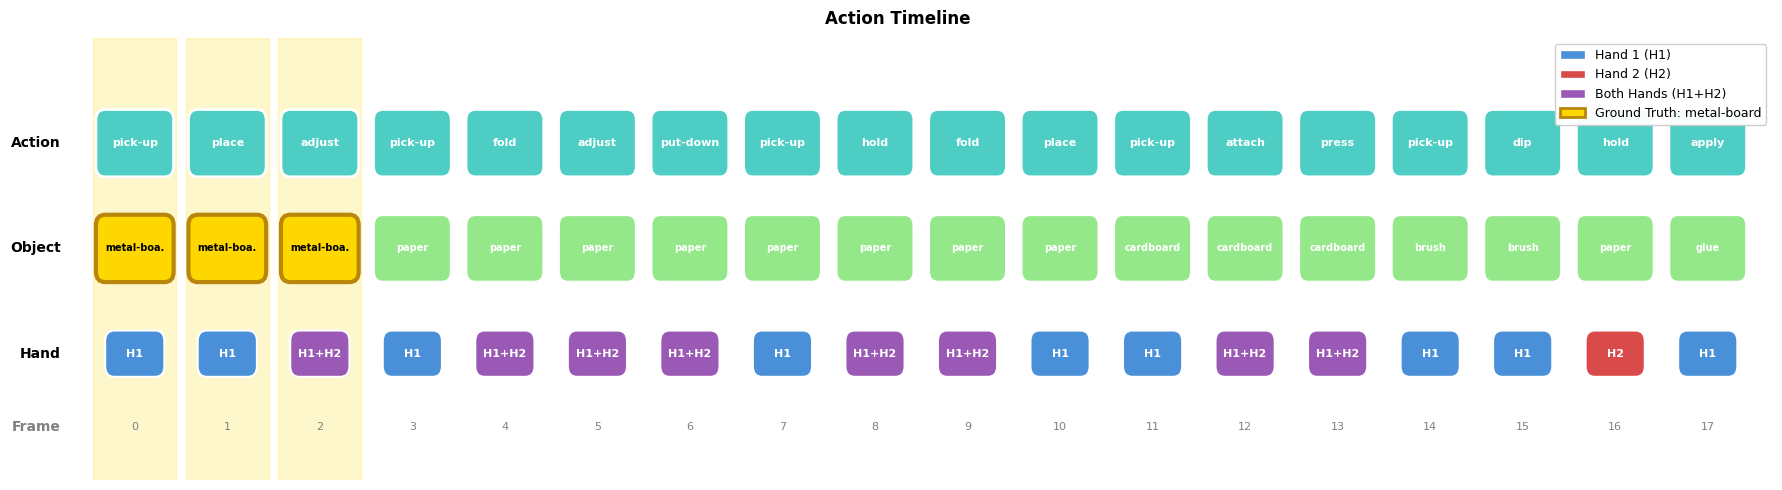

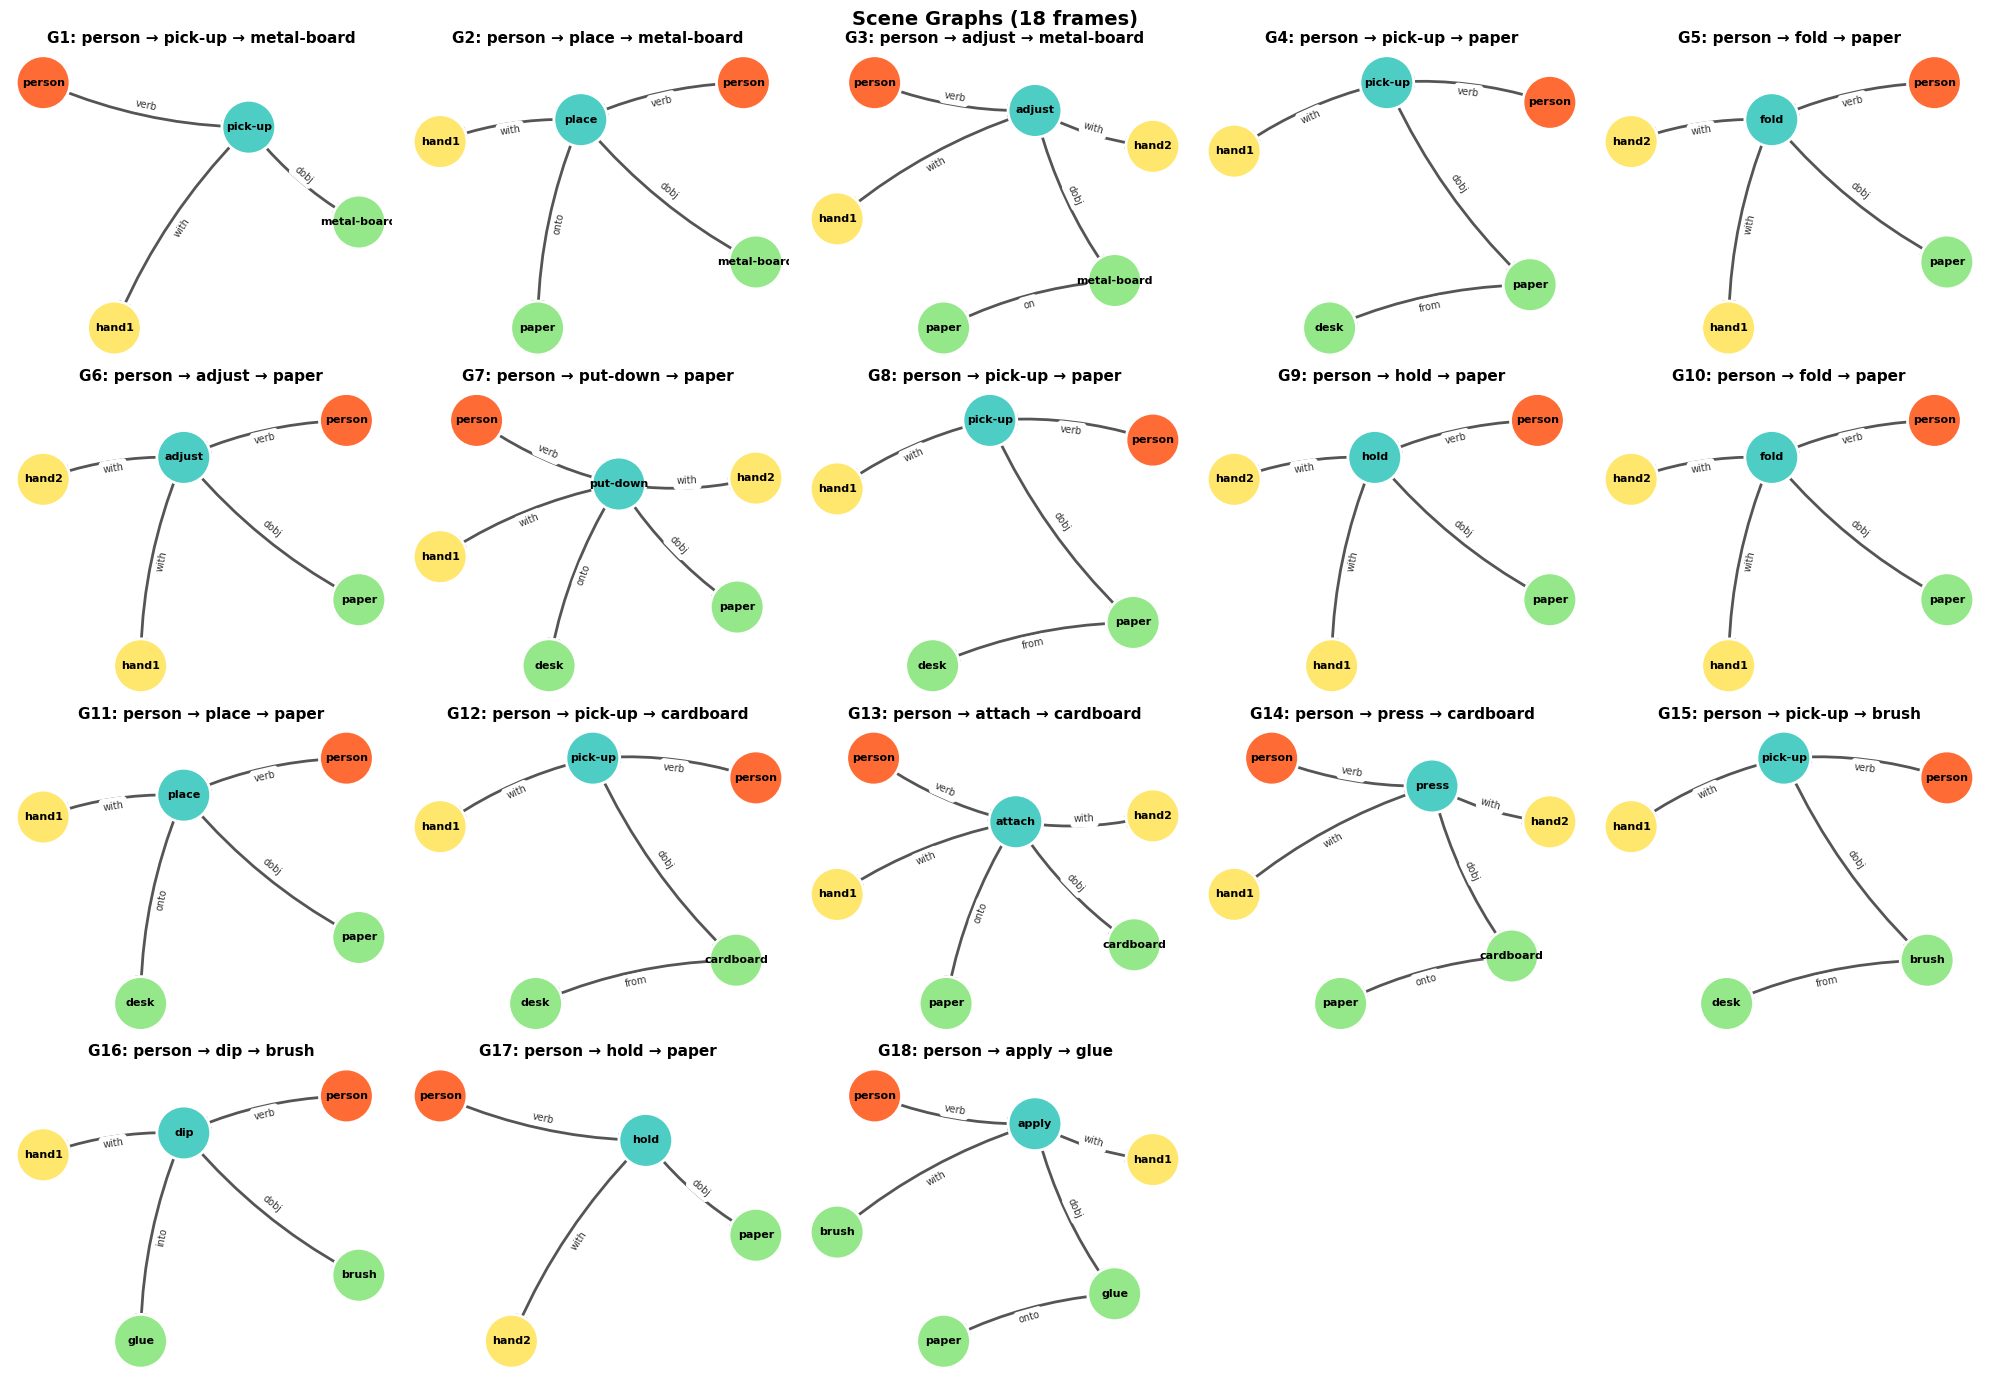

In [3]:
# Case 1
visualize_case(cases[0], 0)

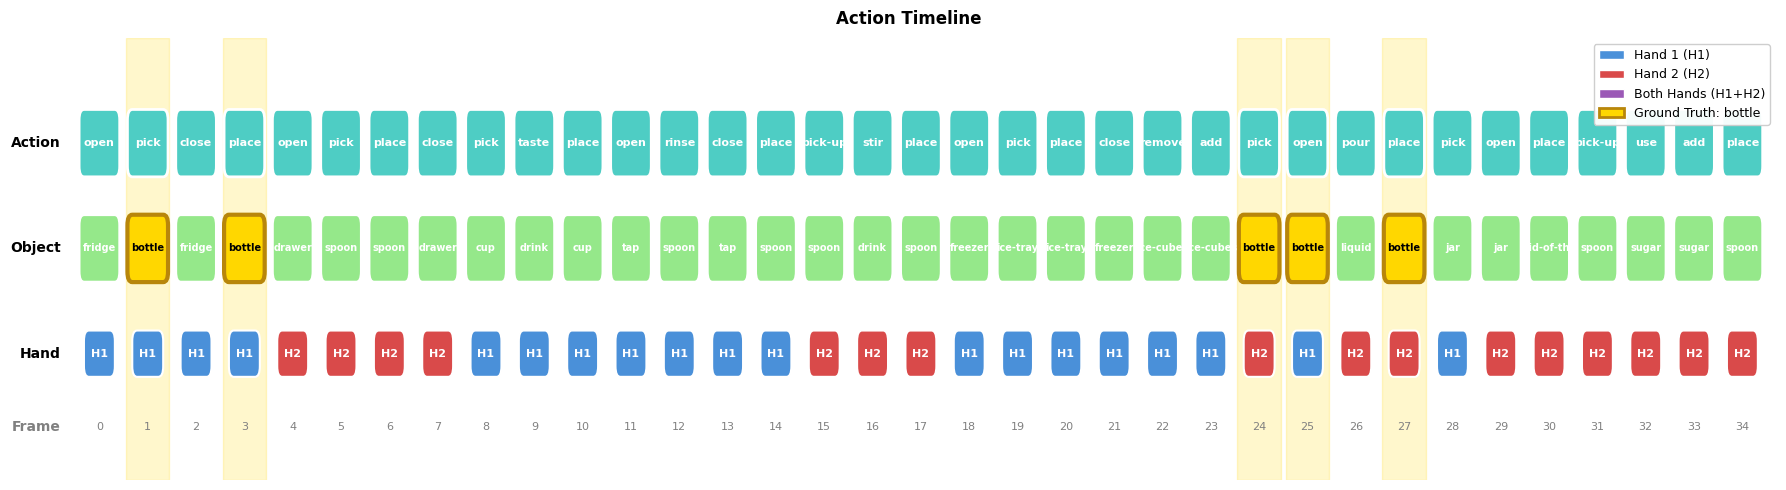

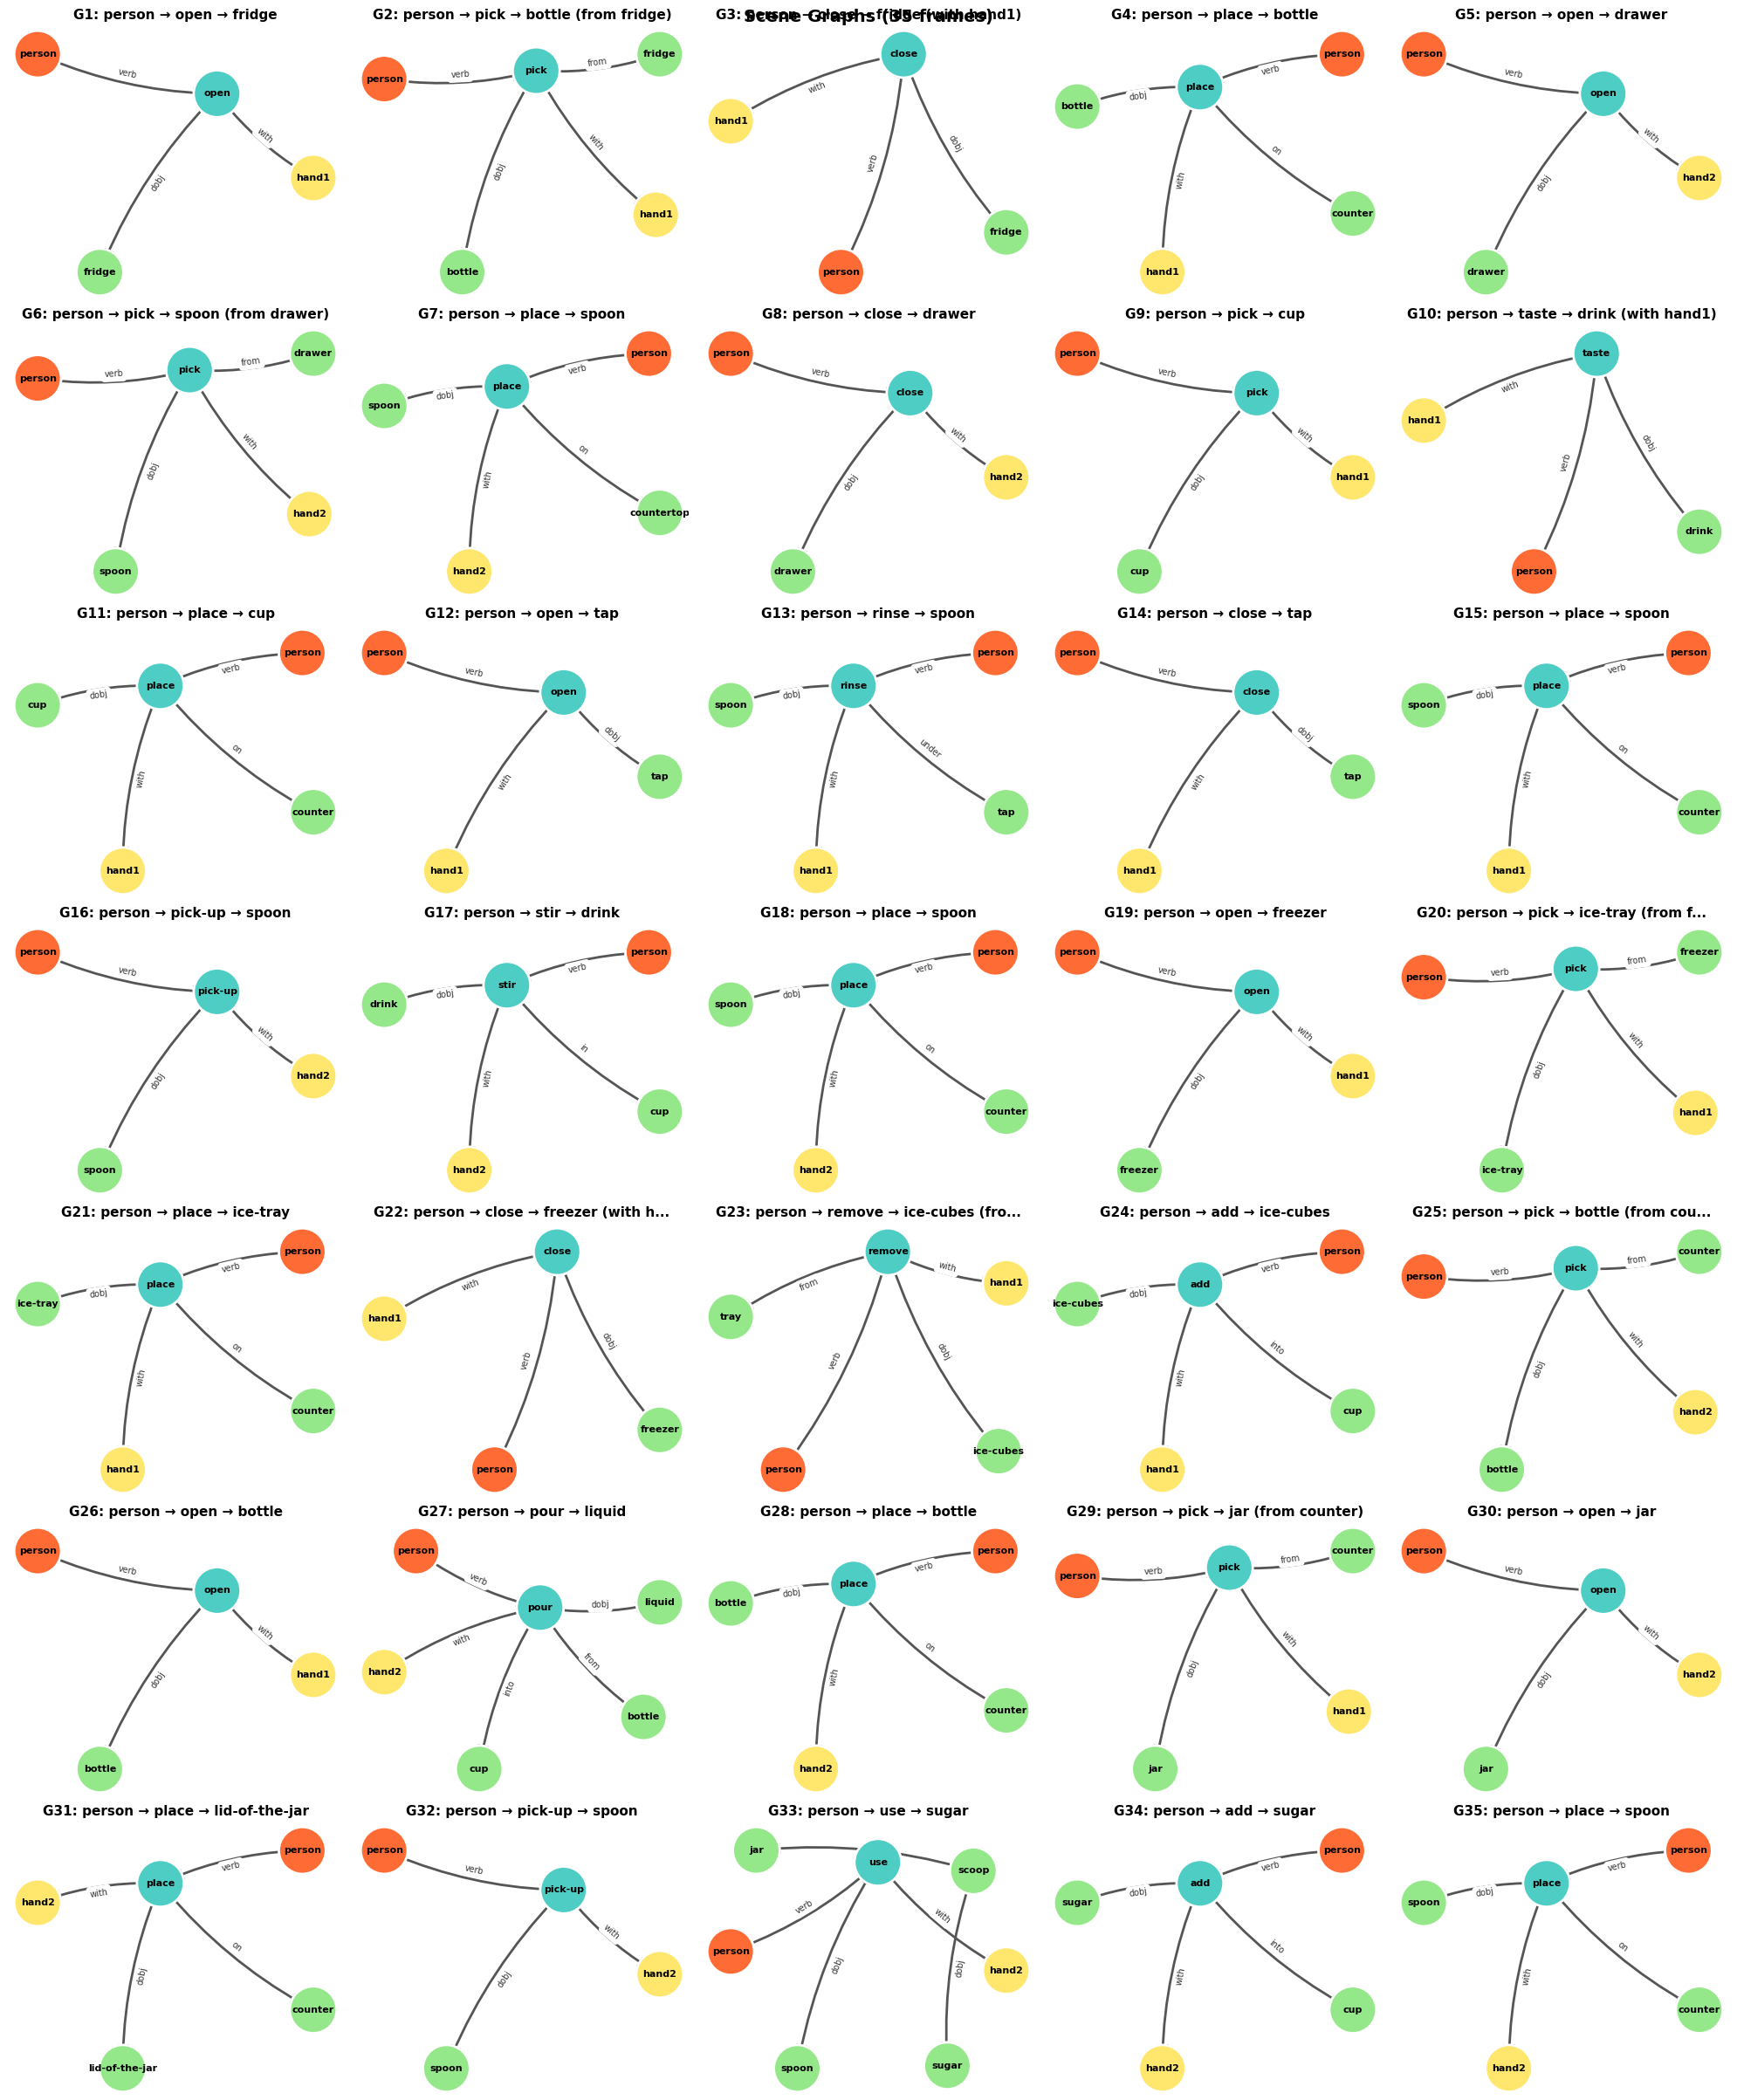

In [4]:
# Case 2
visualize_case(cases[1], 1)

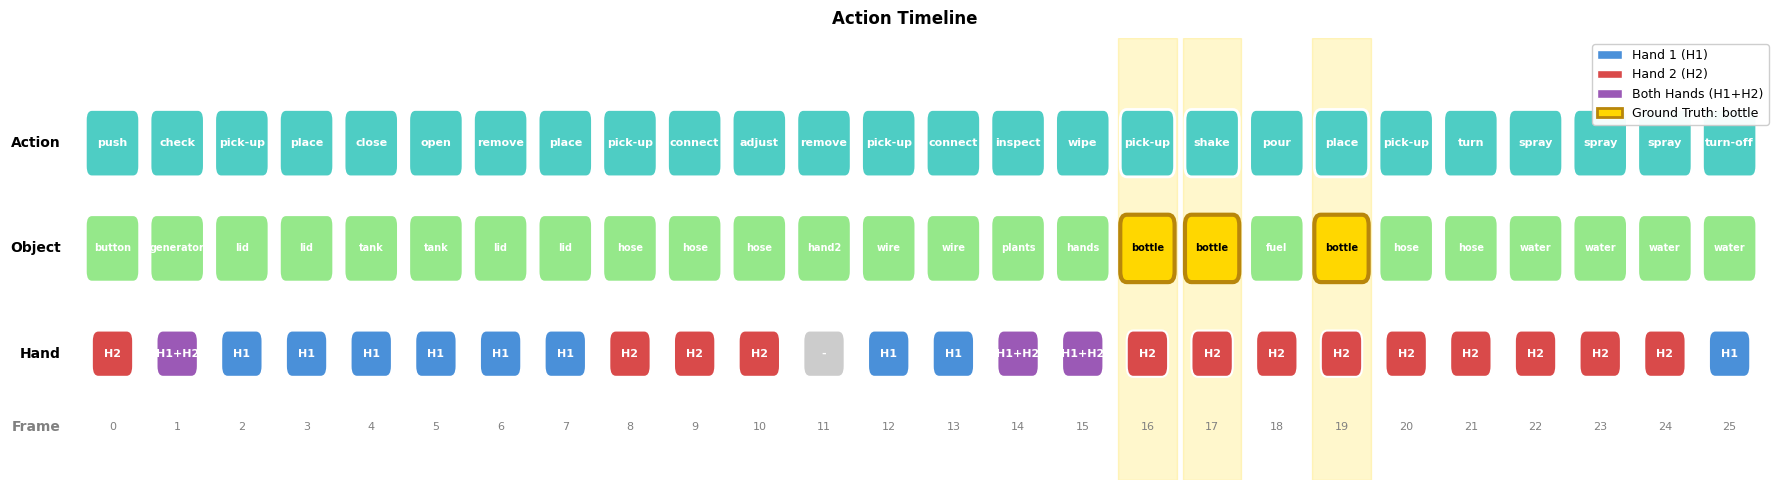

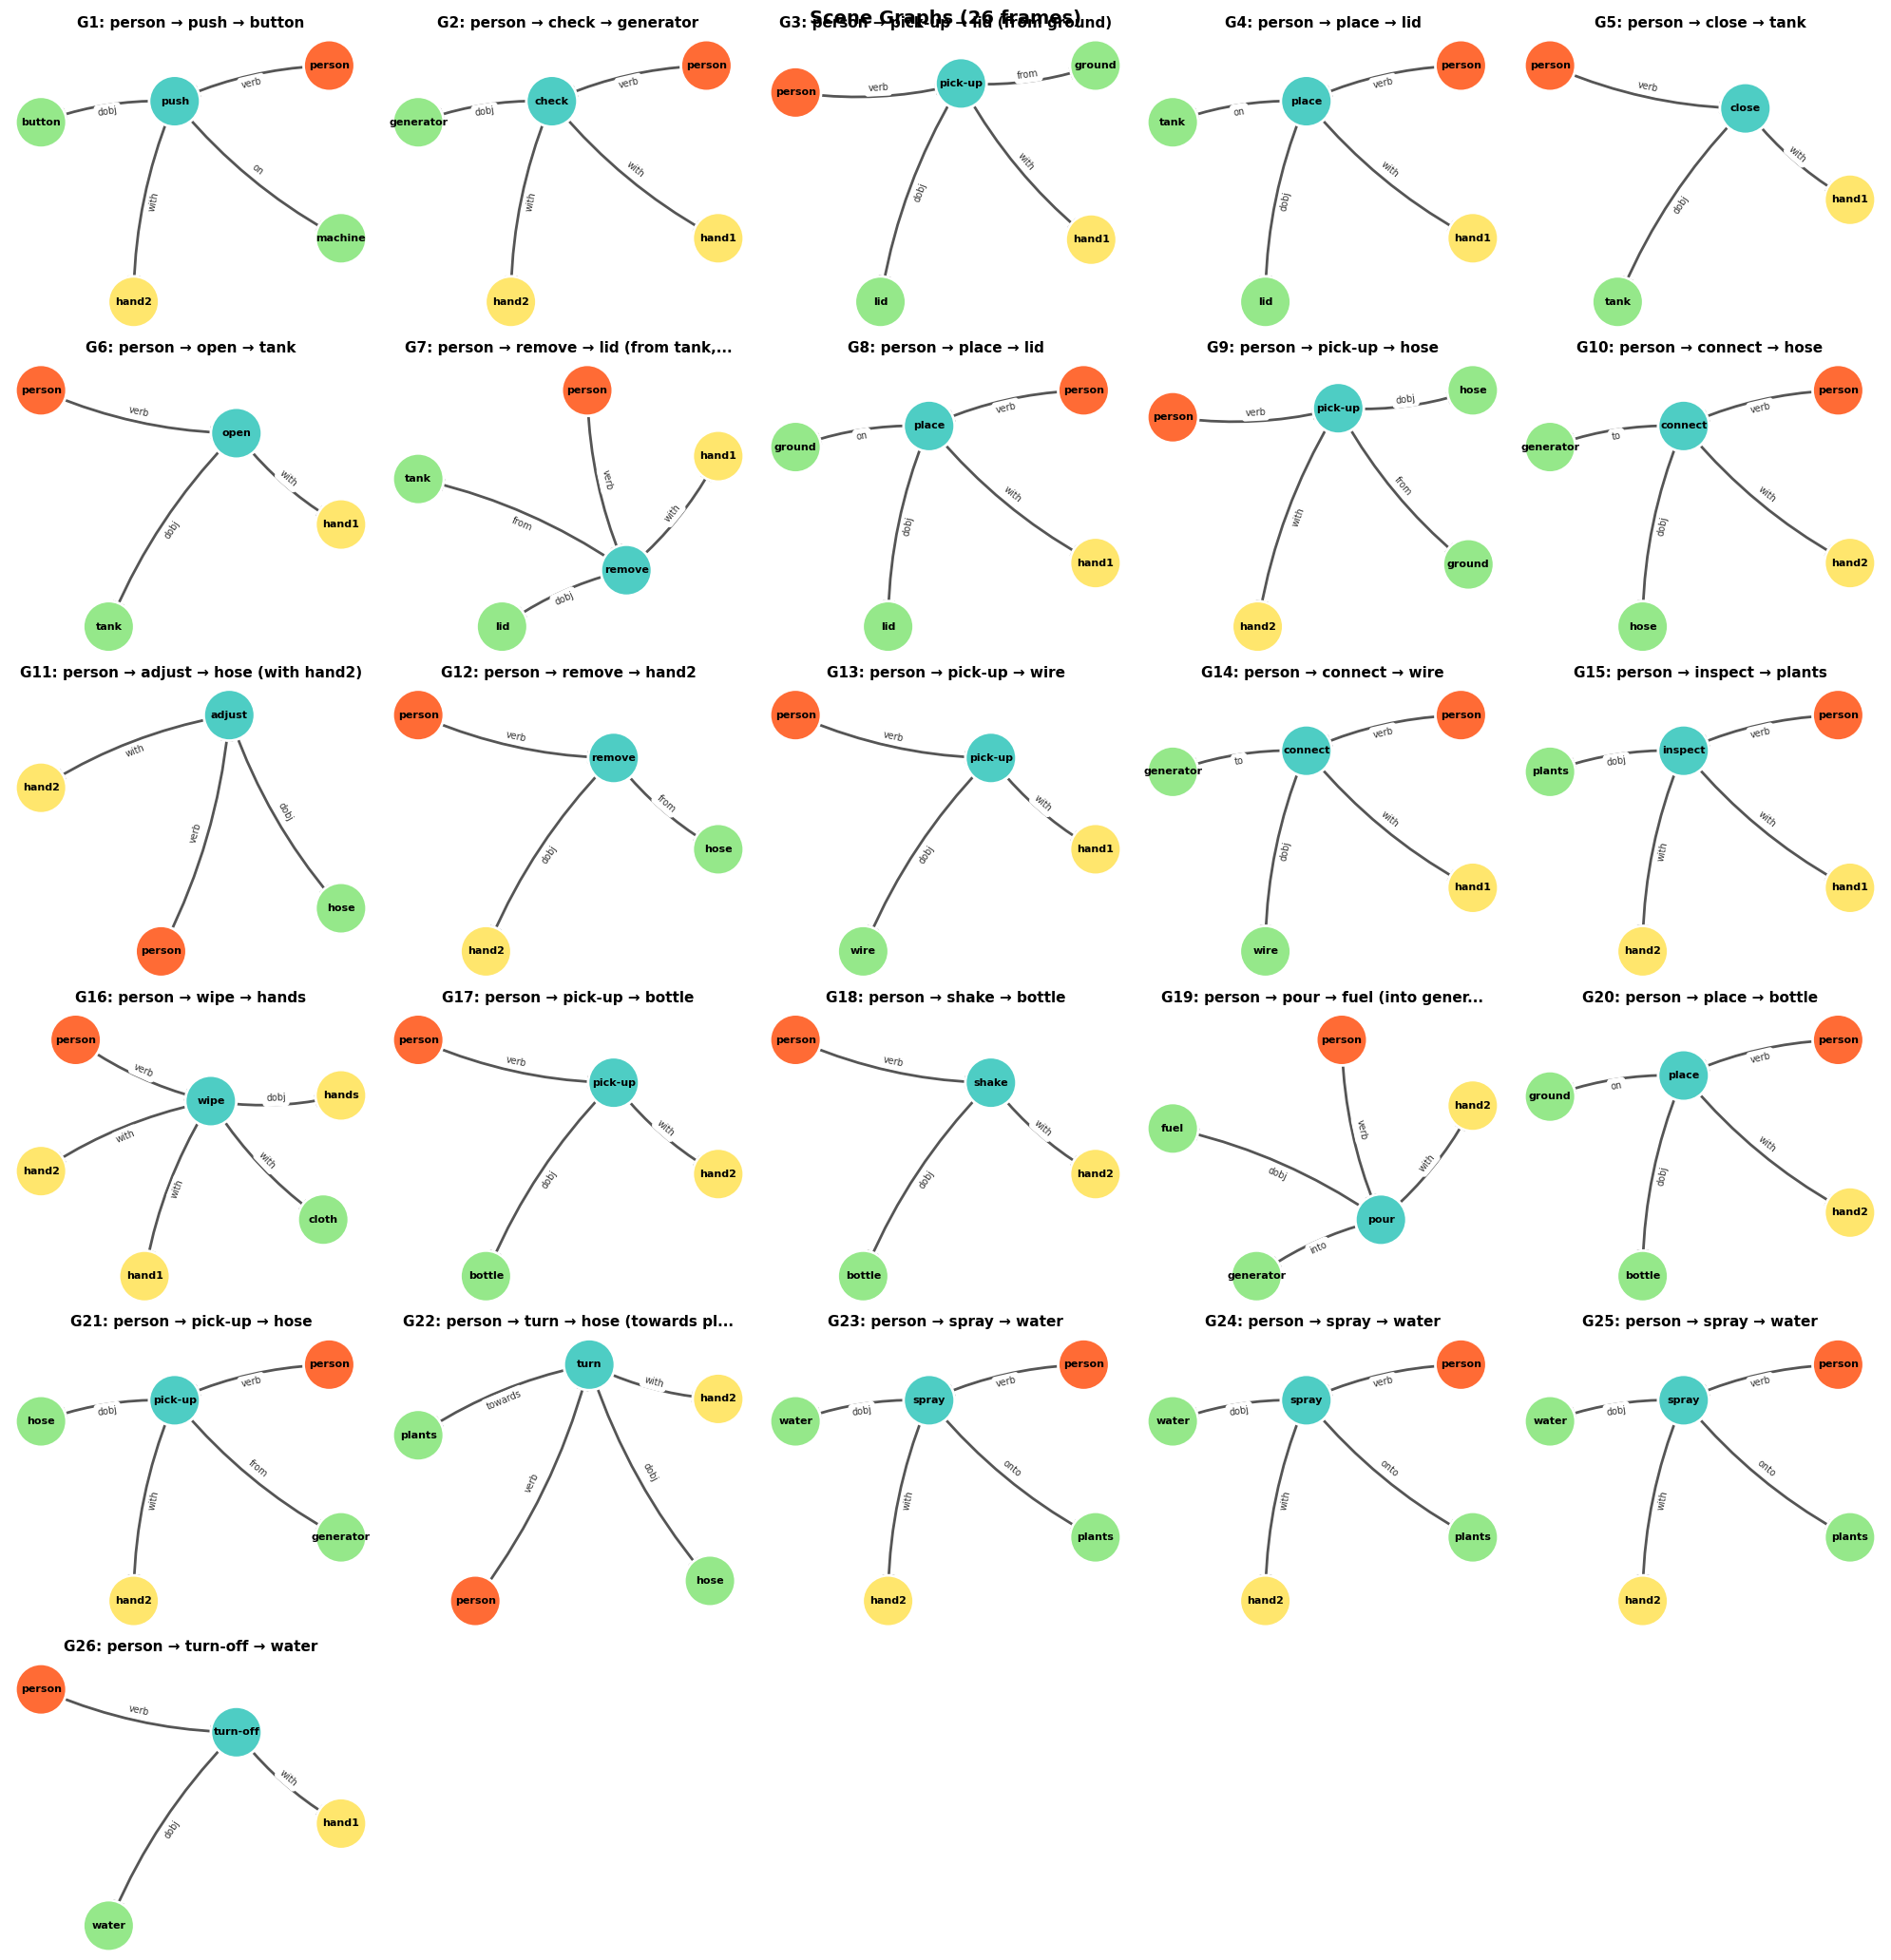

In [5]:
# Case 3
visualize_case(cases[2], 2)

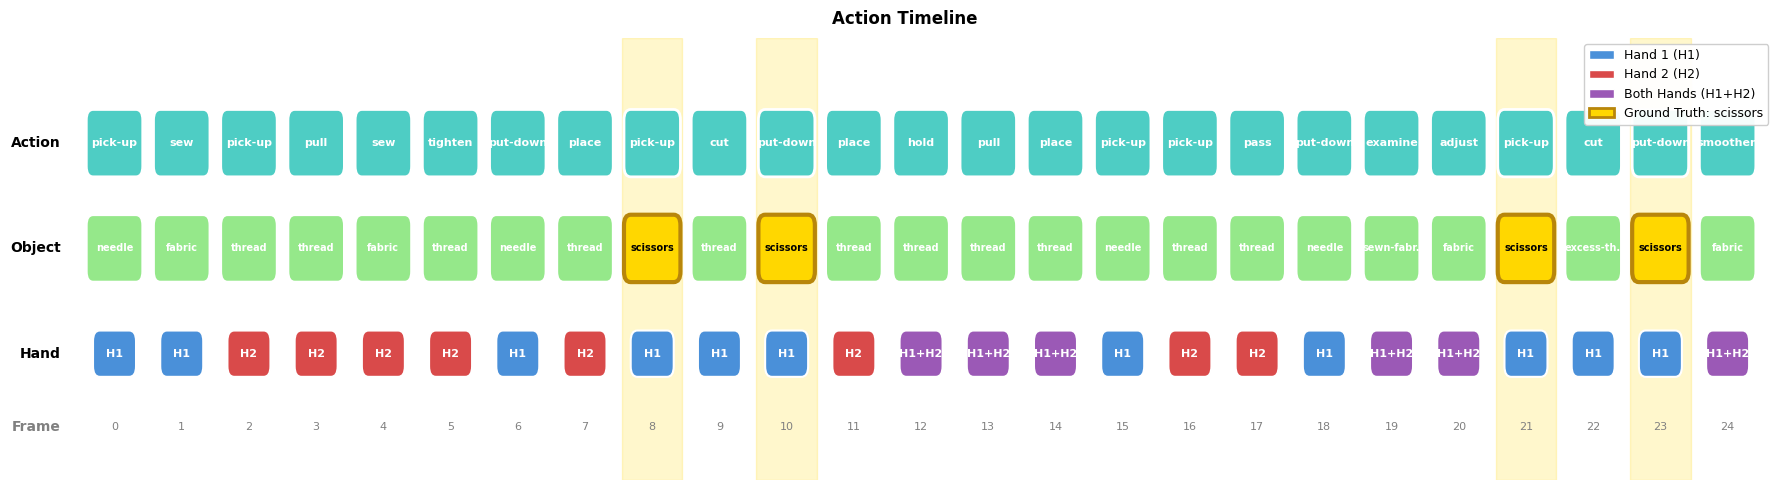

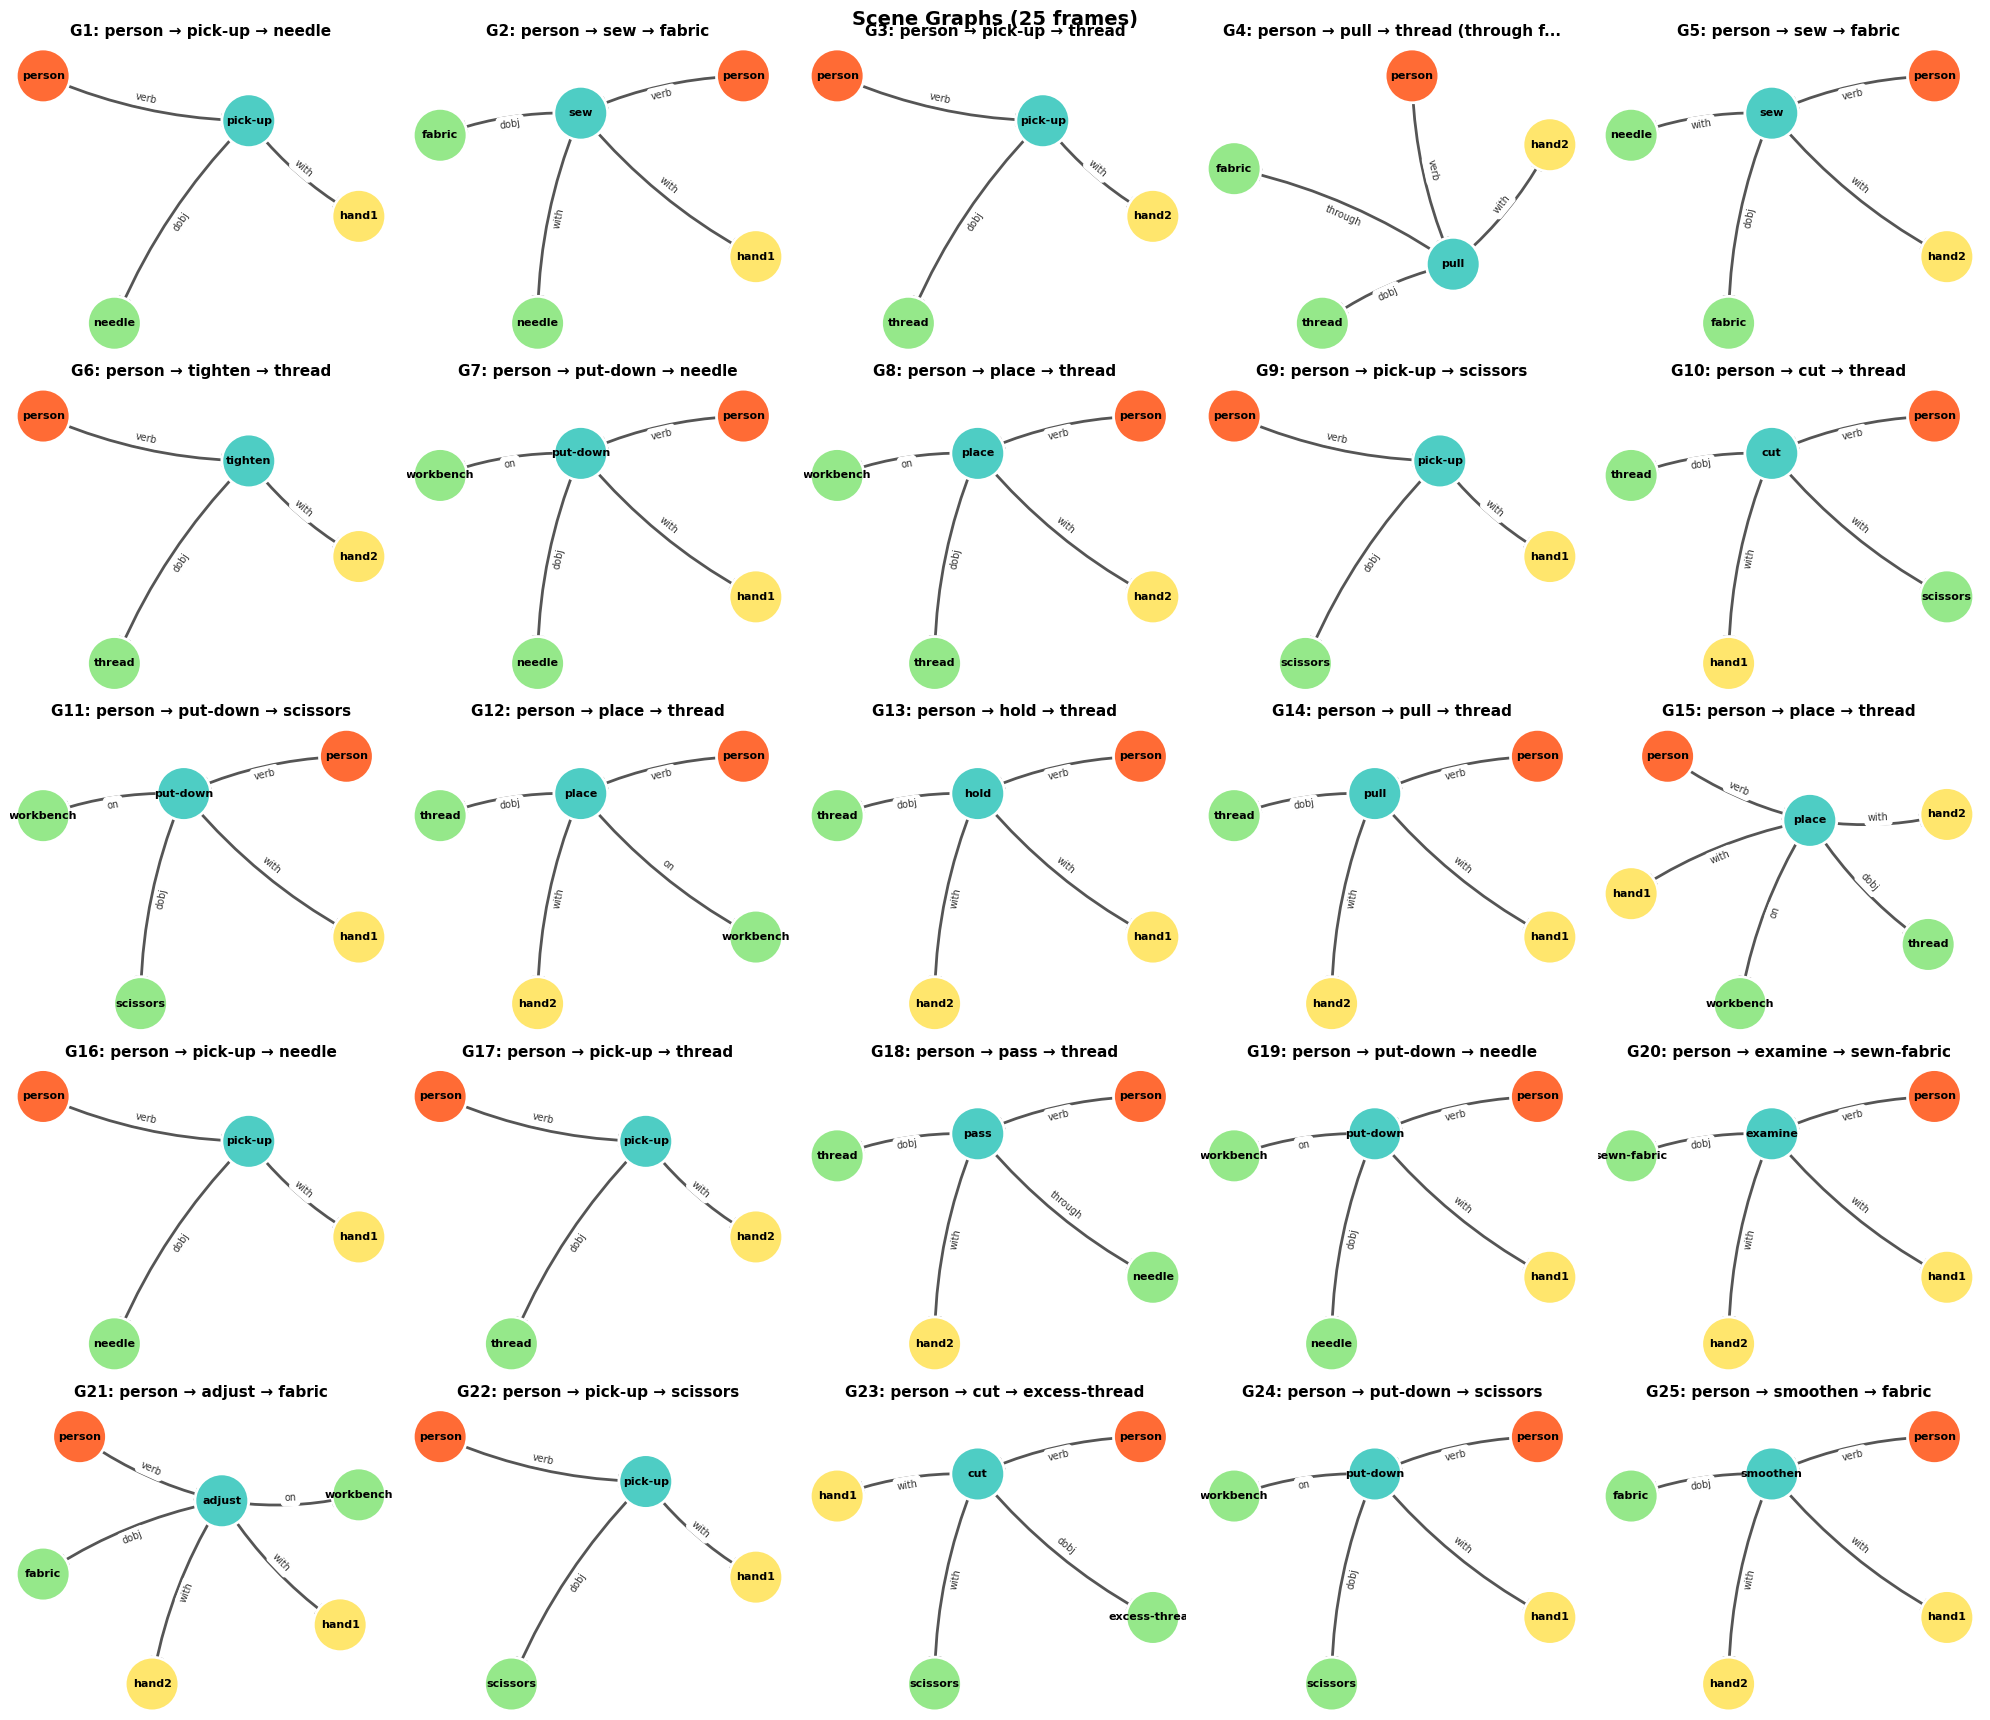

In [6]:
# Case 4
visualize_case(cases[3], 3)

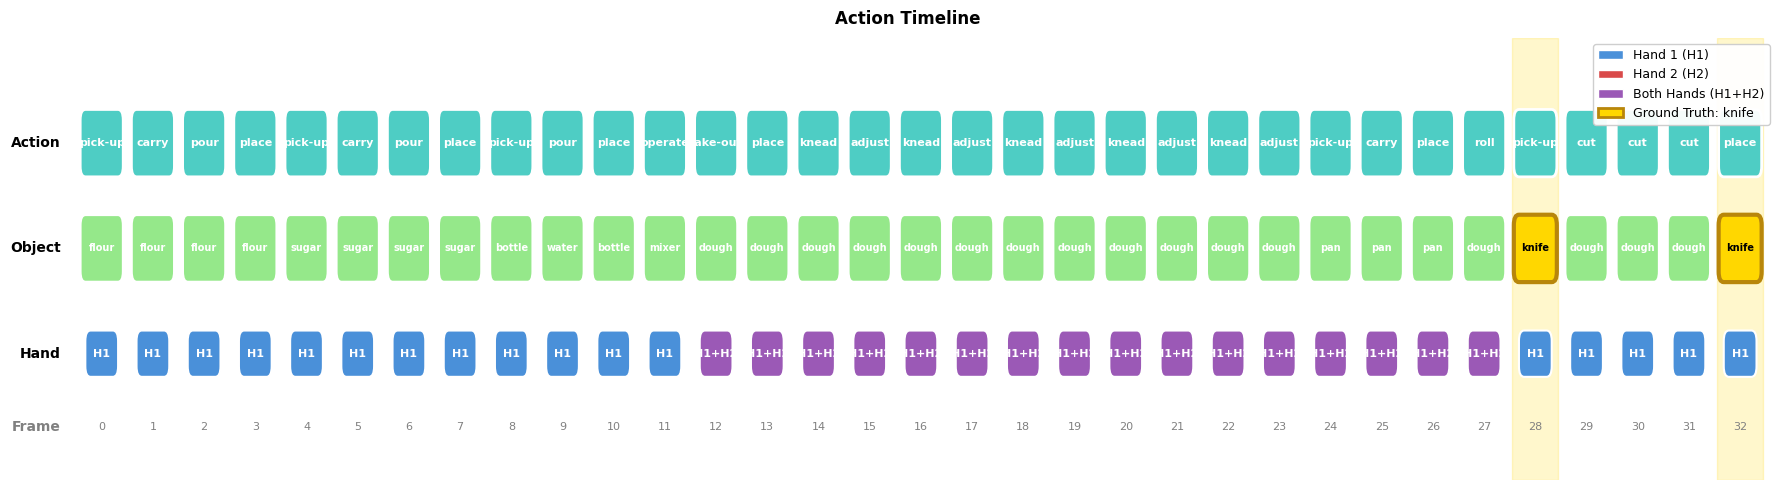

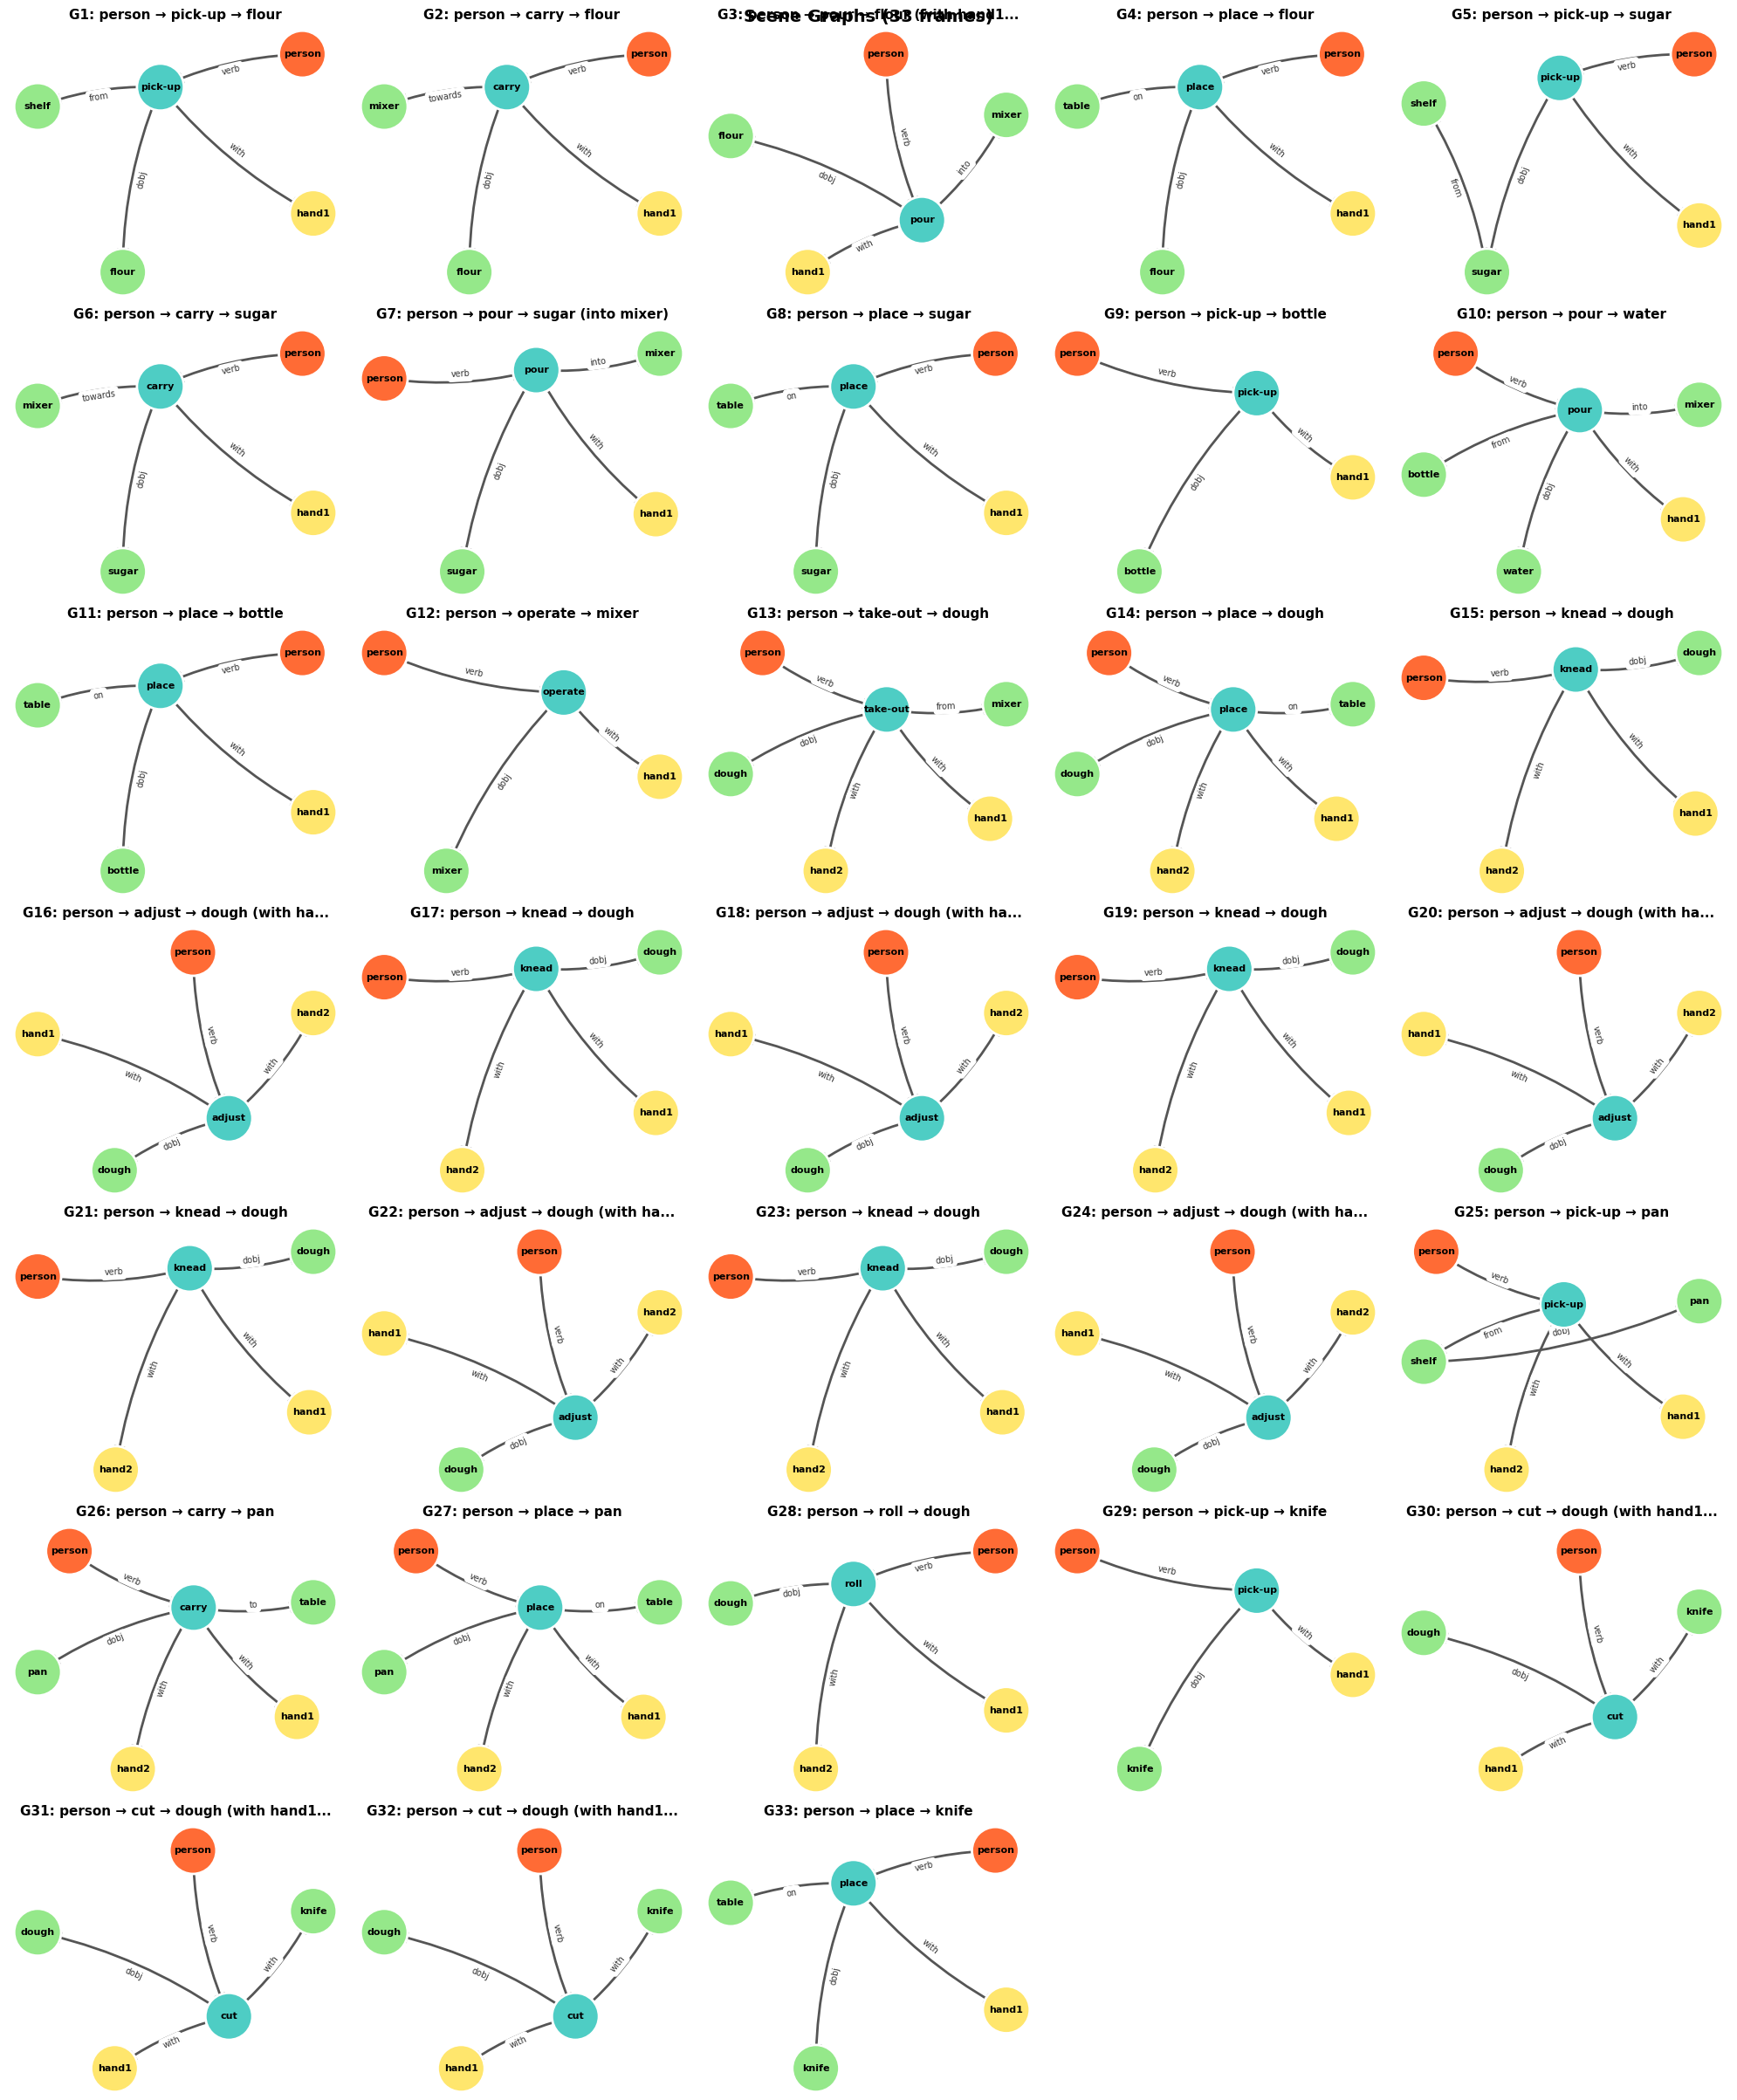

In [7]:
# Case 5
visualize_case(cases[4], 4)

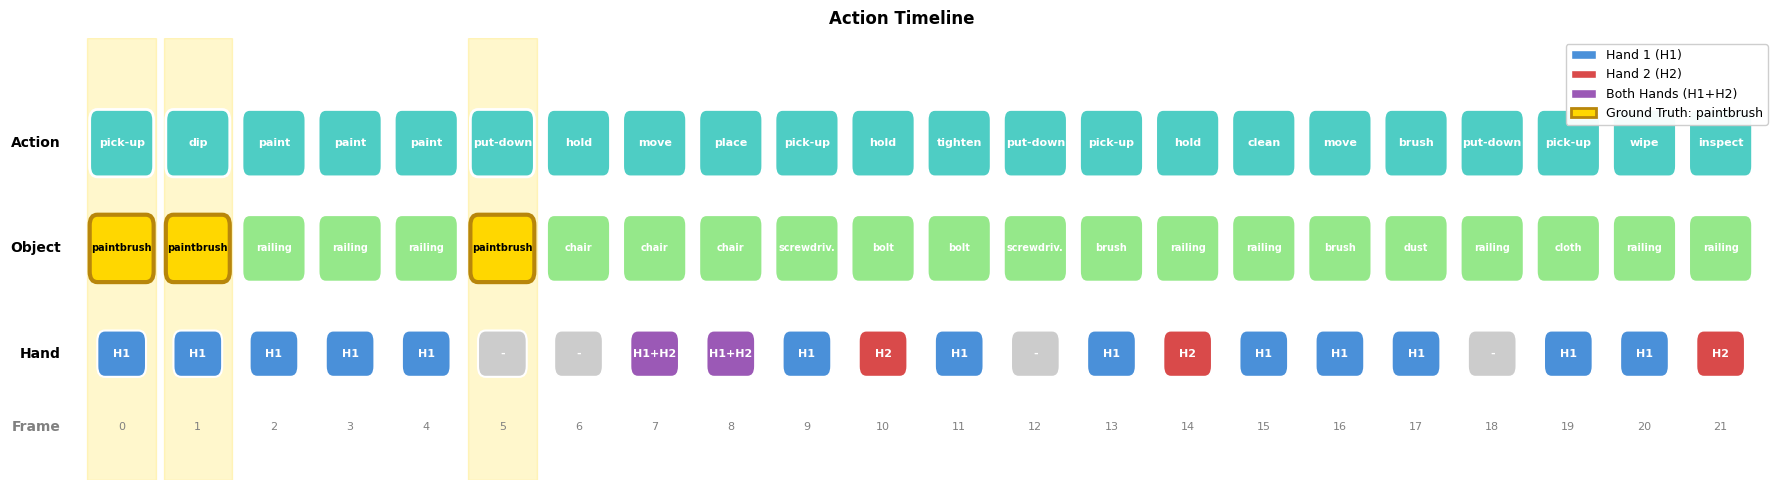

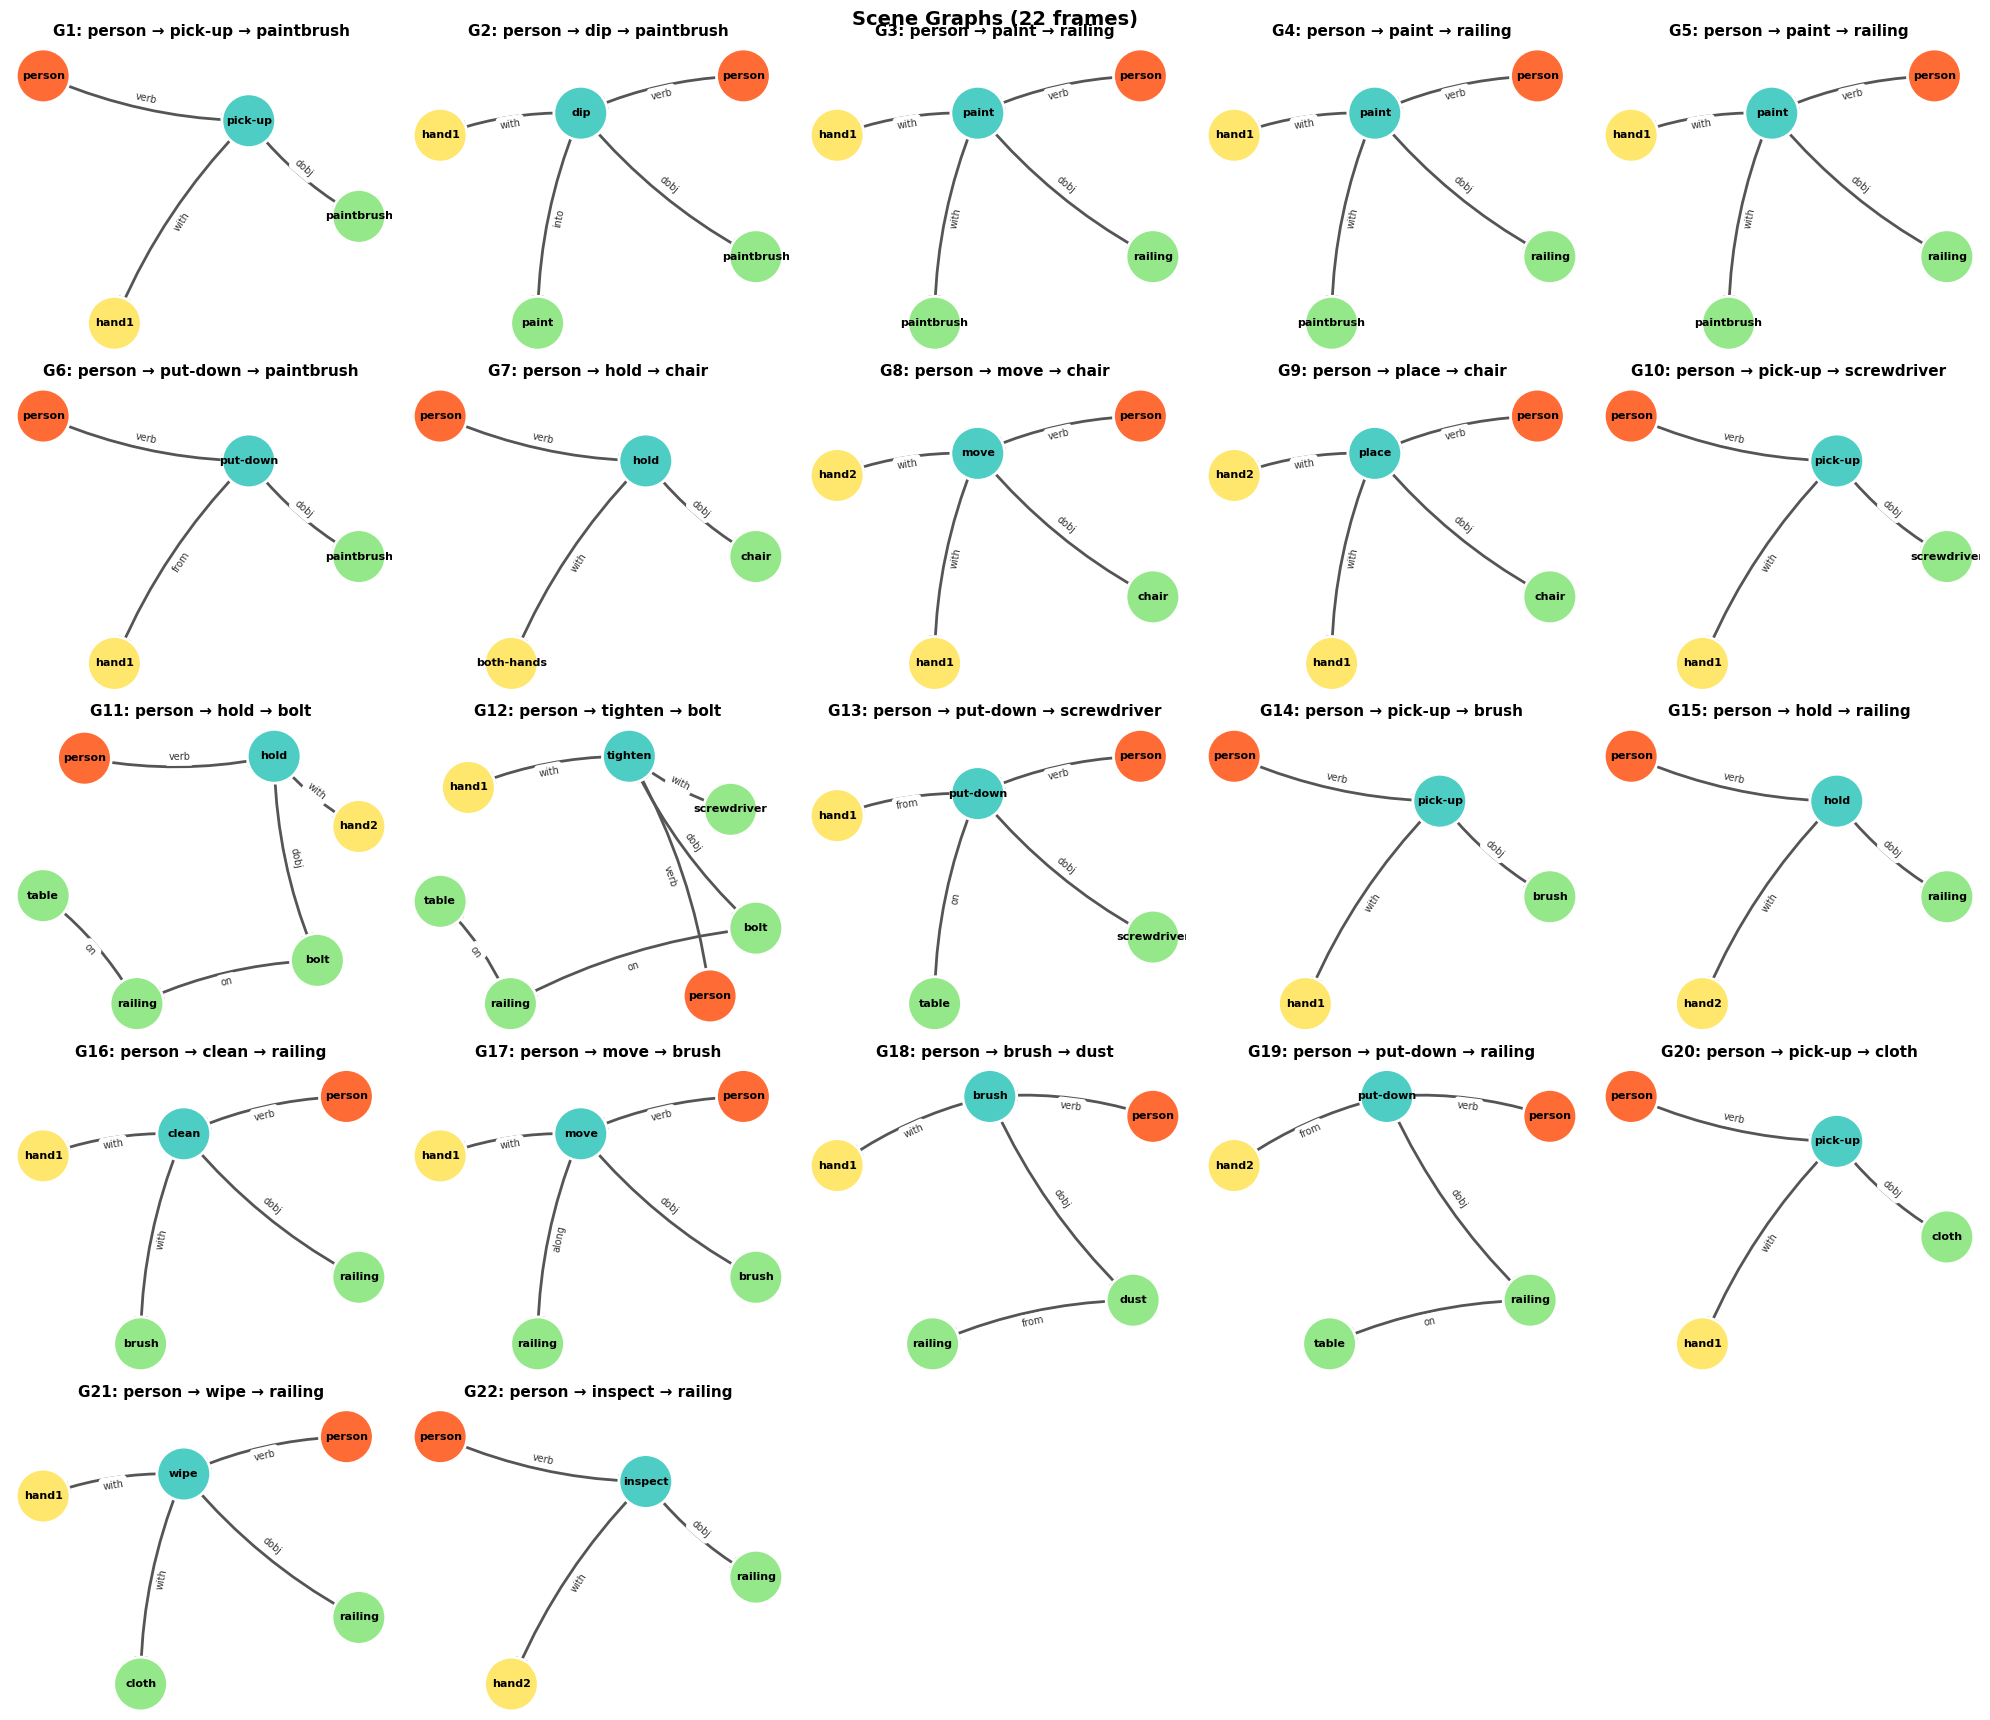

In [8]:
# Case 6
visualize_case(cases[5], 5)

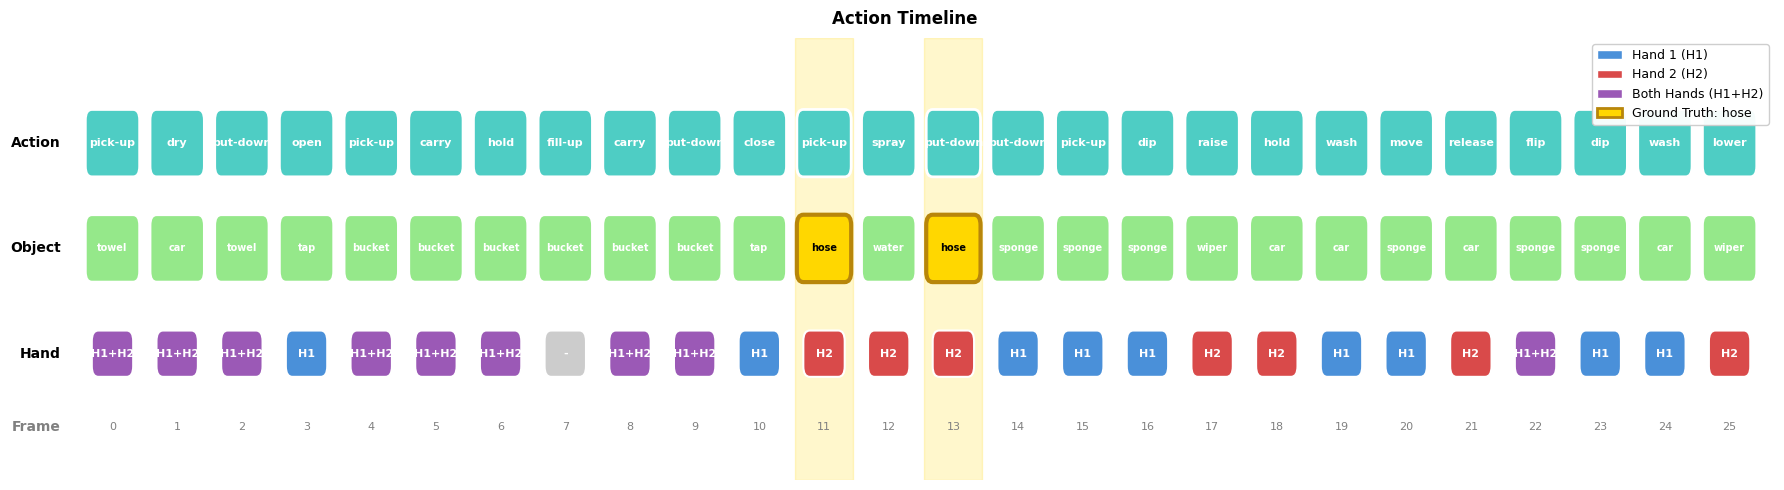

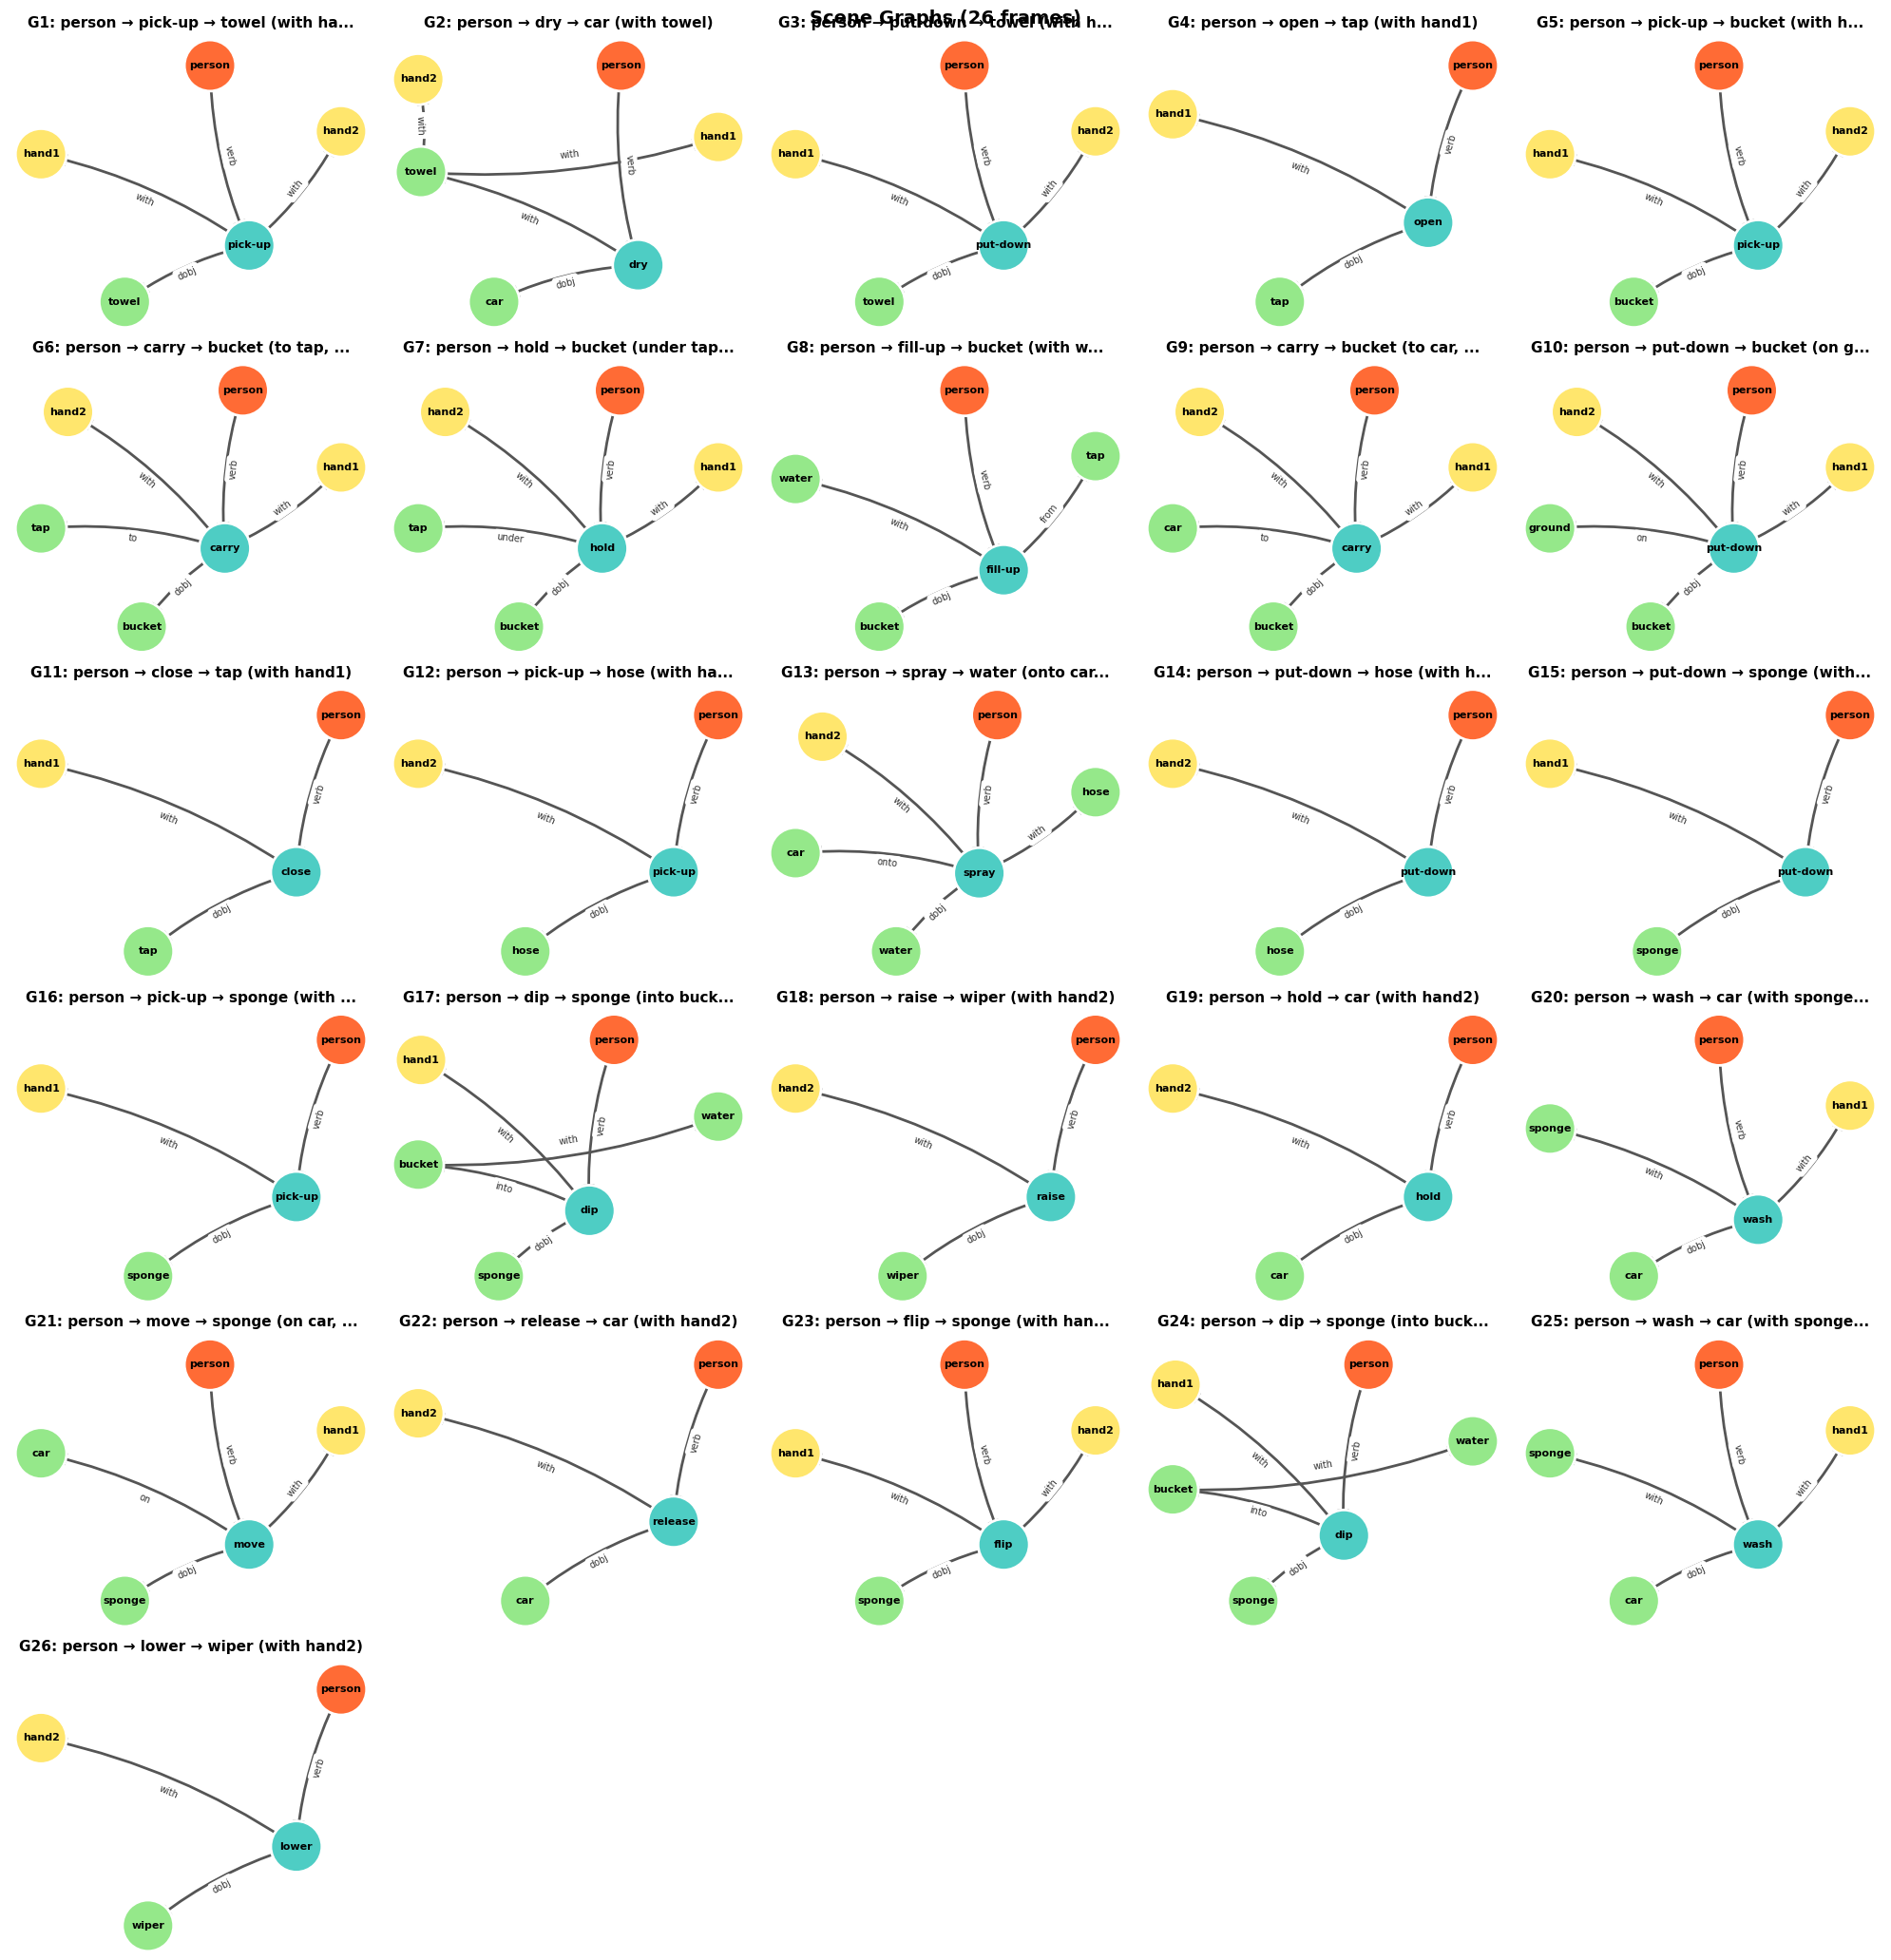

In [9]:
# Case 7
visualize_case(cases[6], 6)

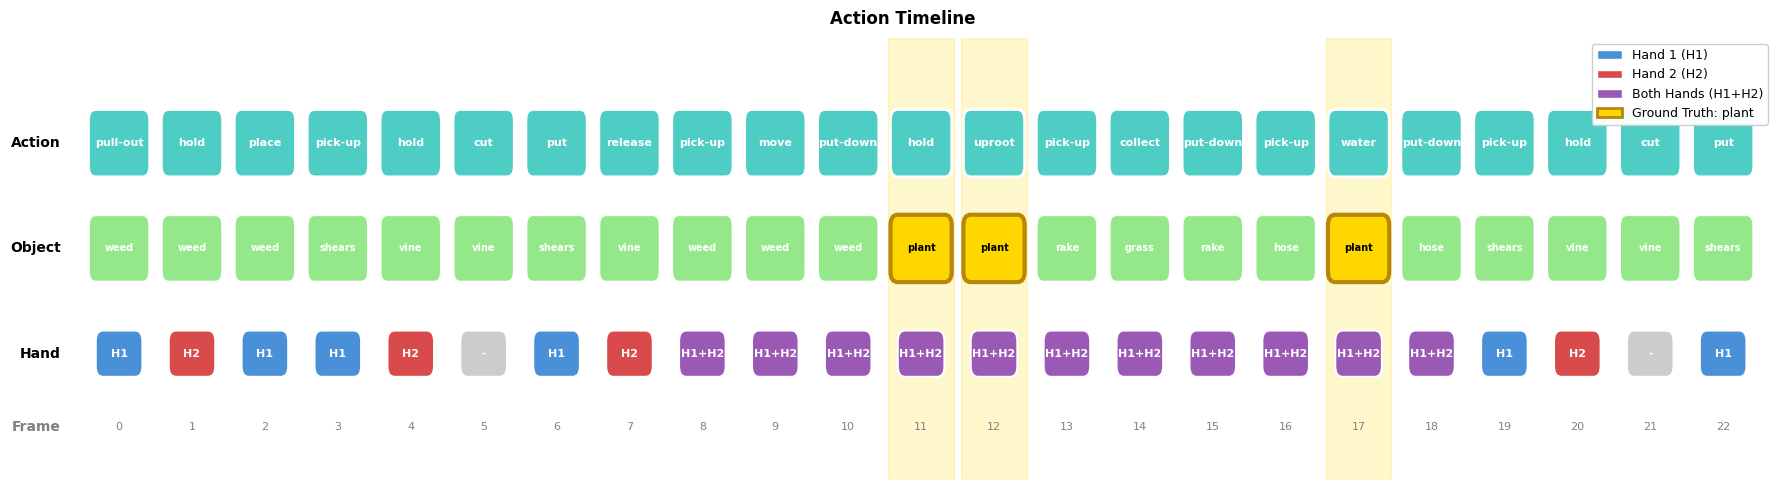

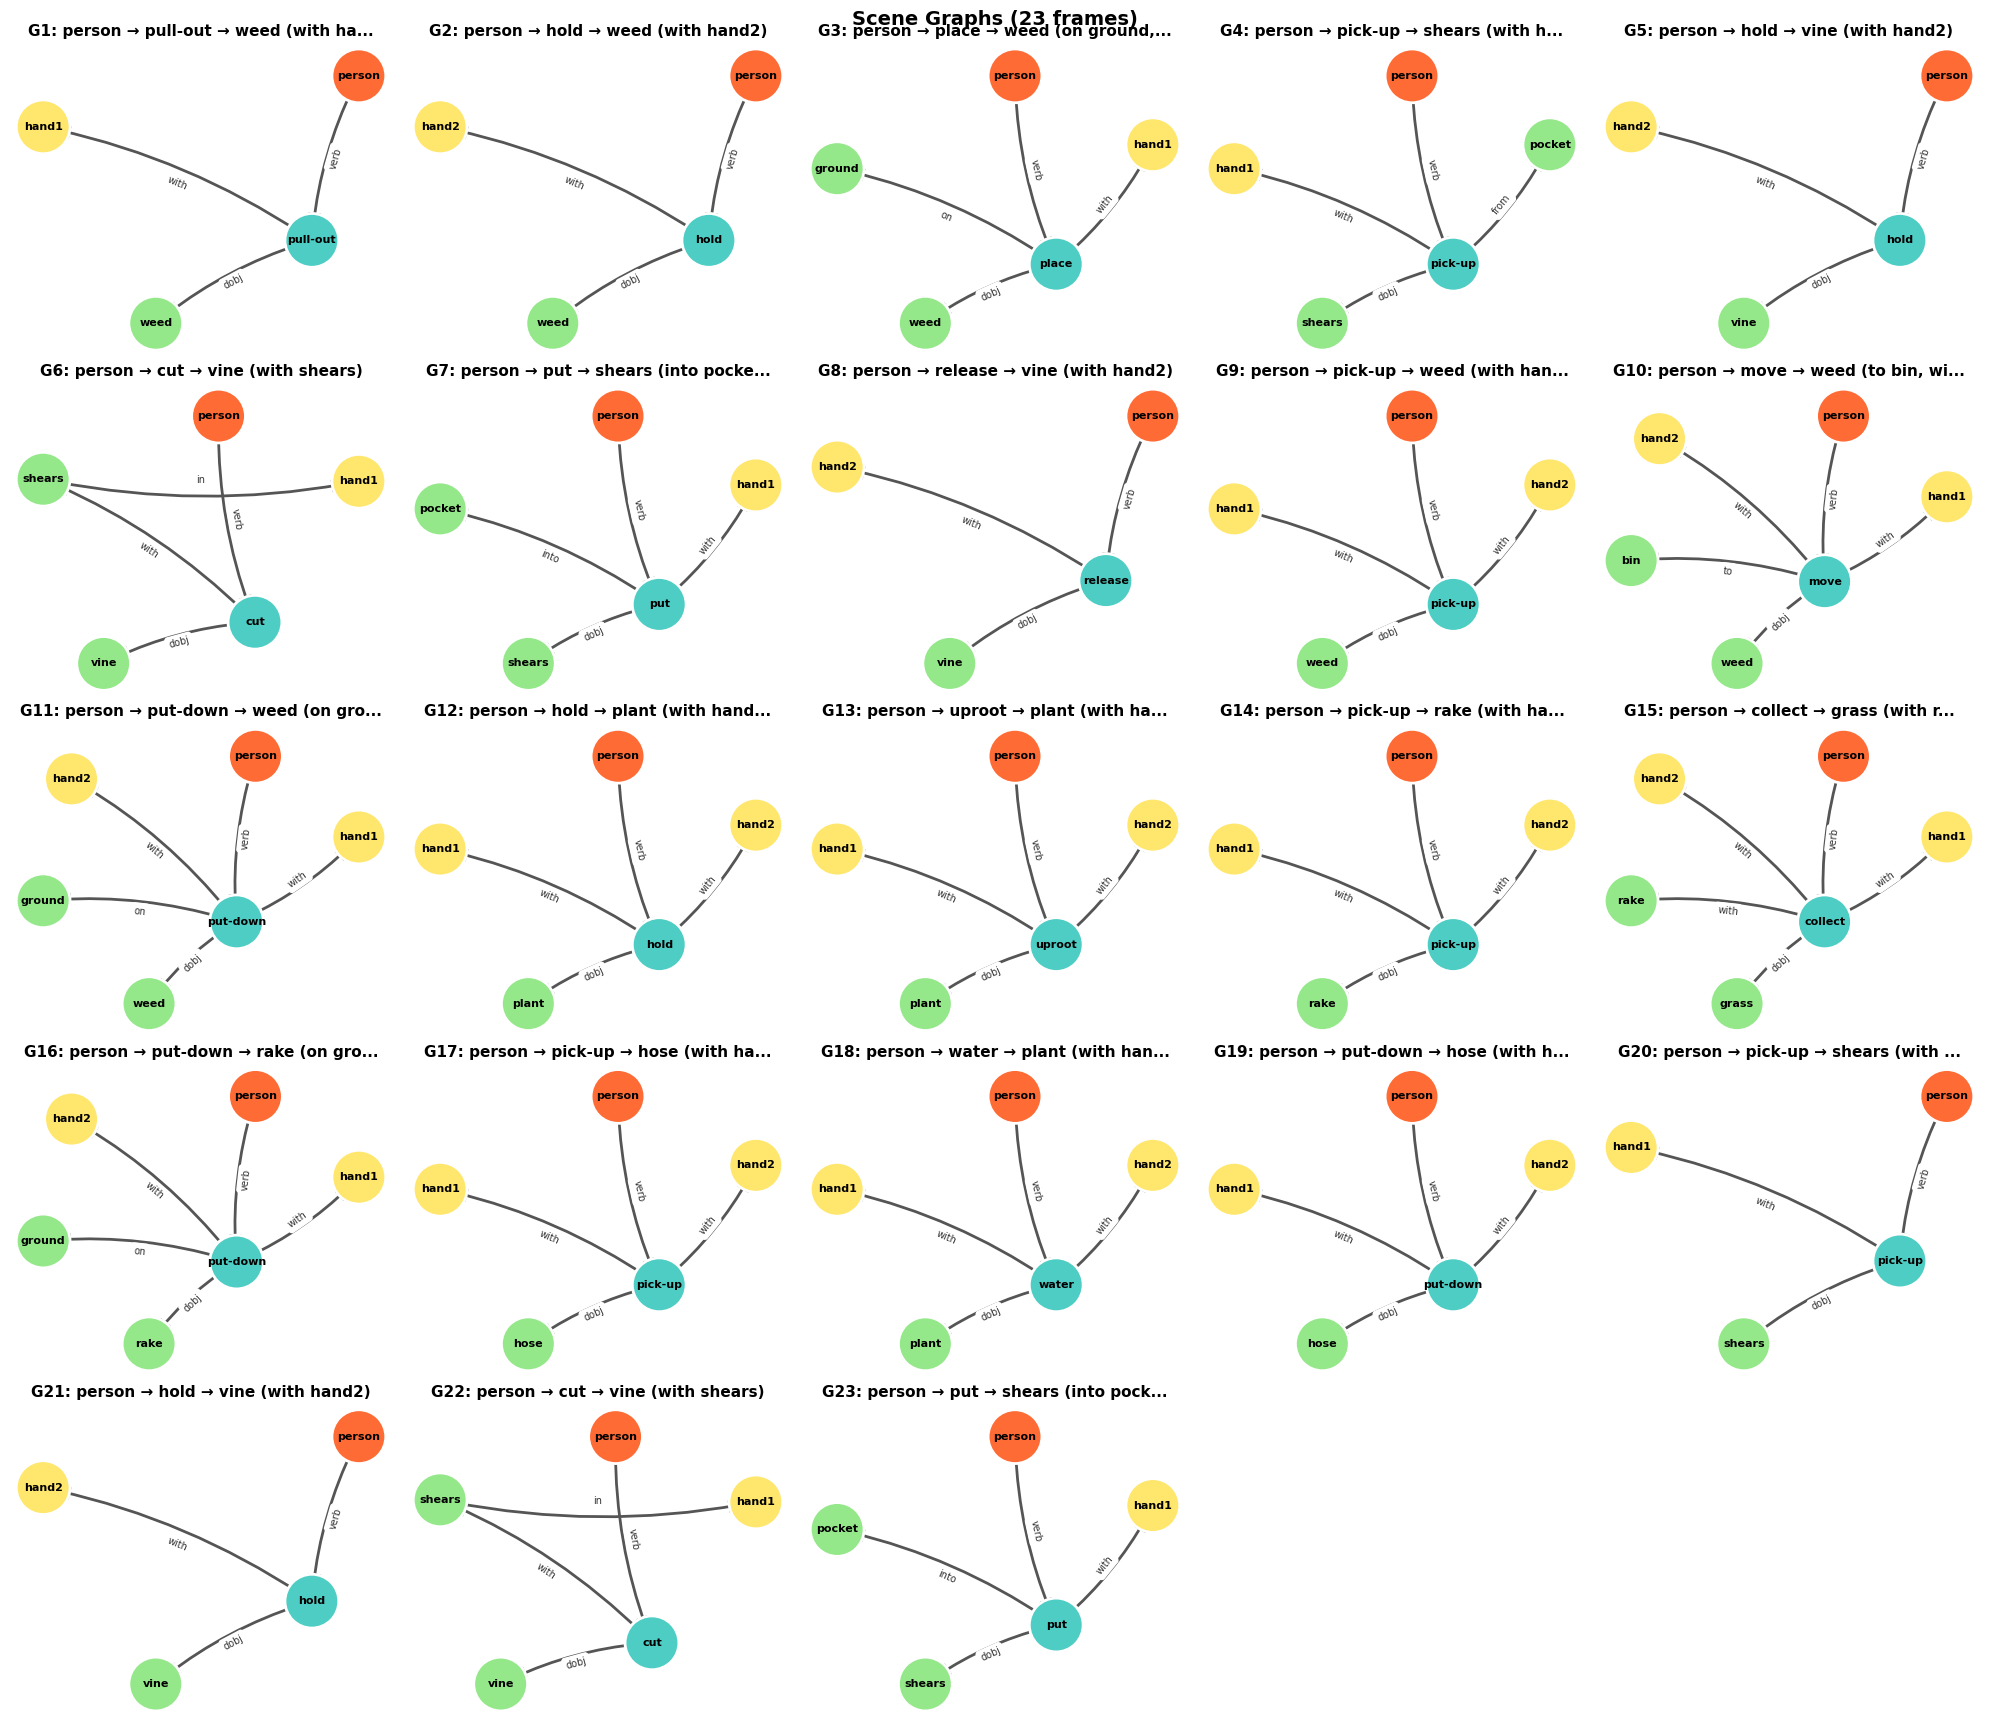

In [10]:
# Case 8
visualize_case(cases[7], 7)

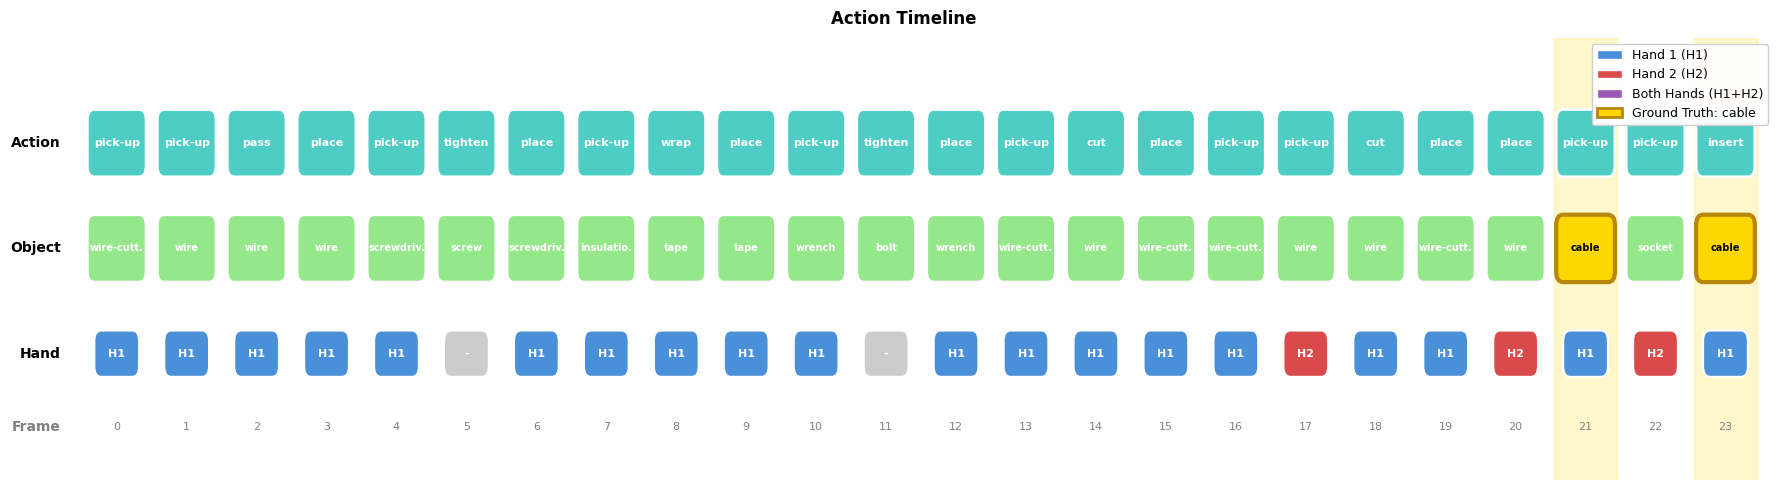

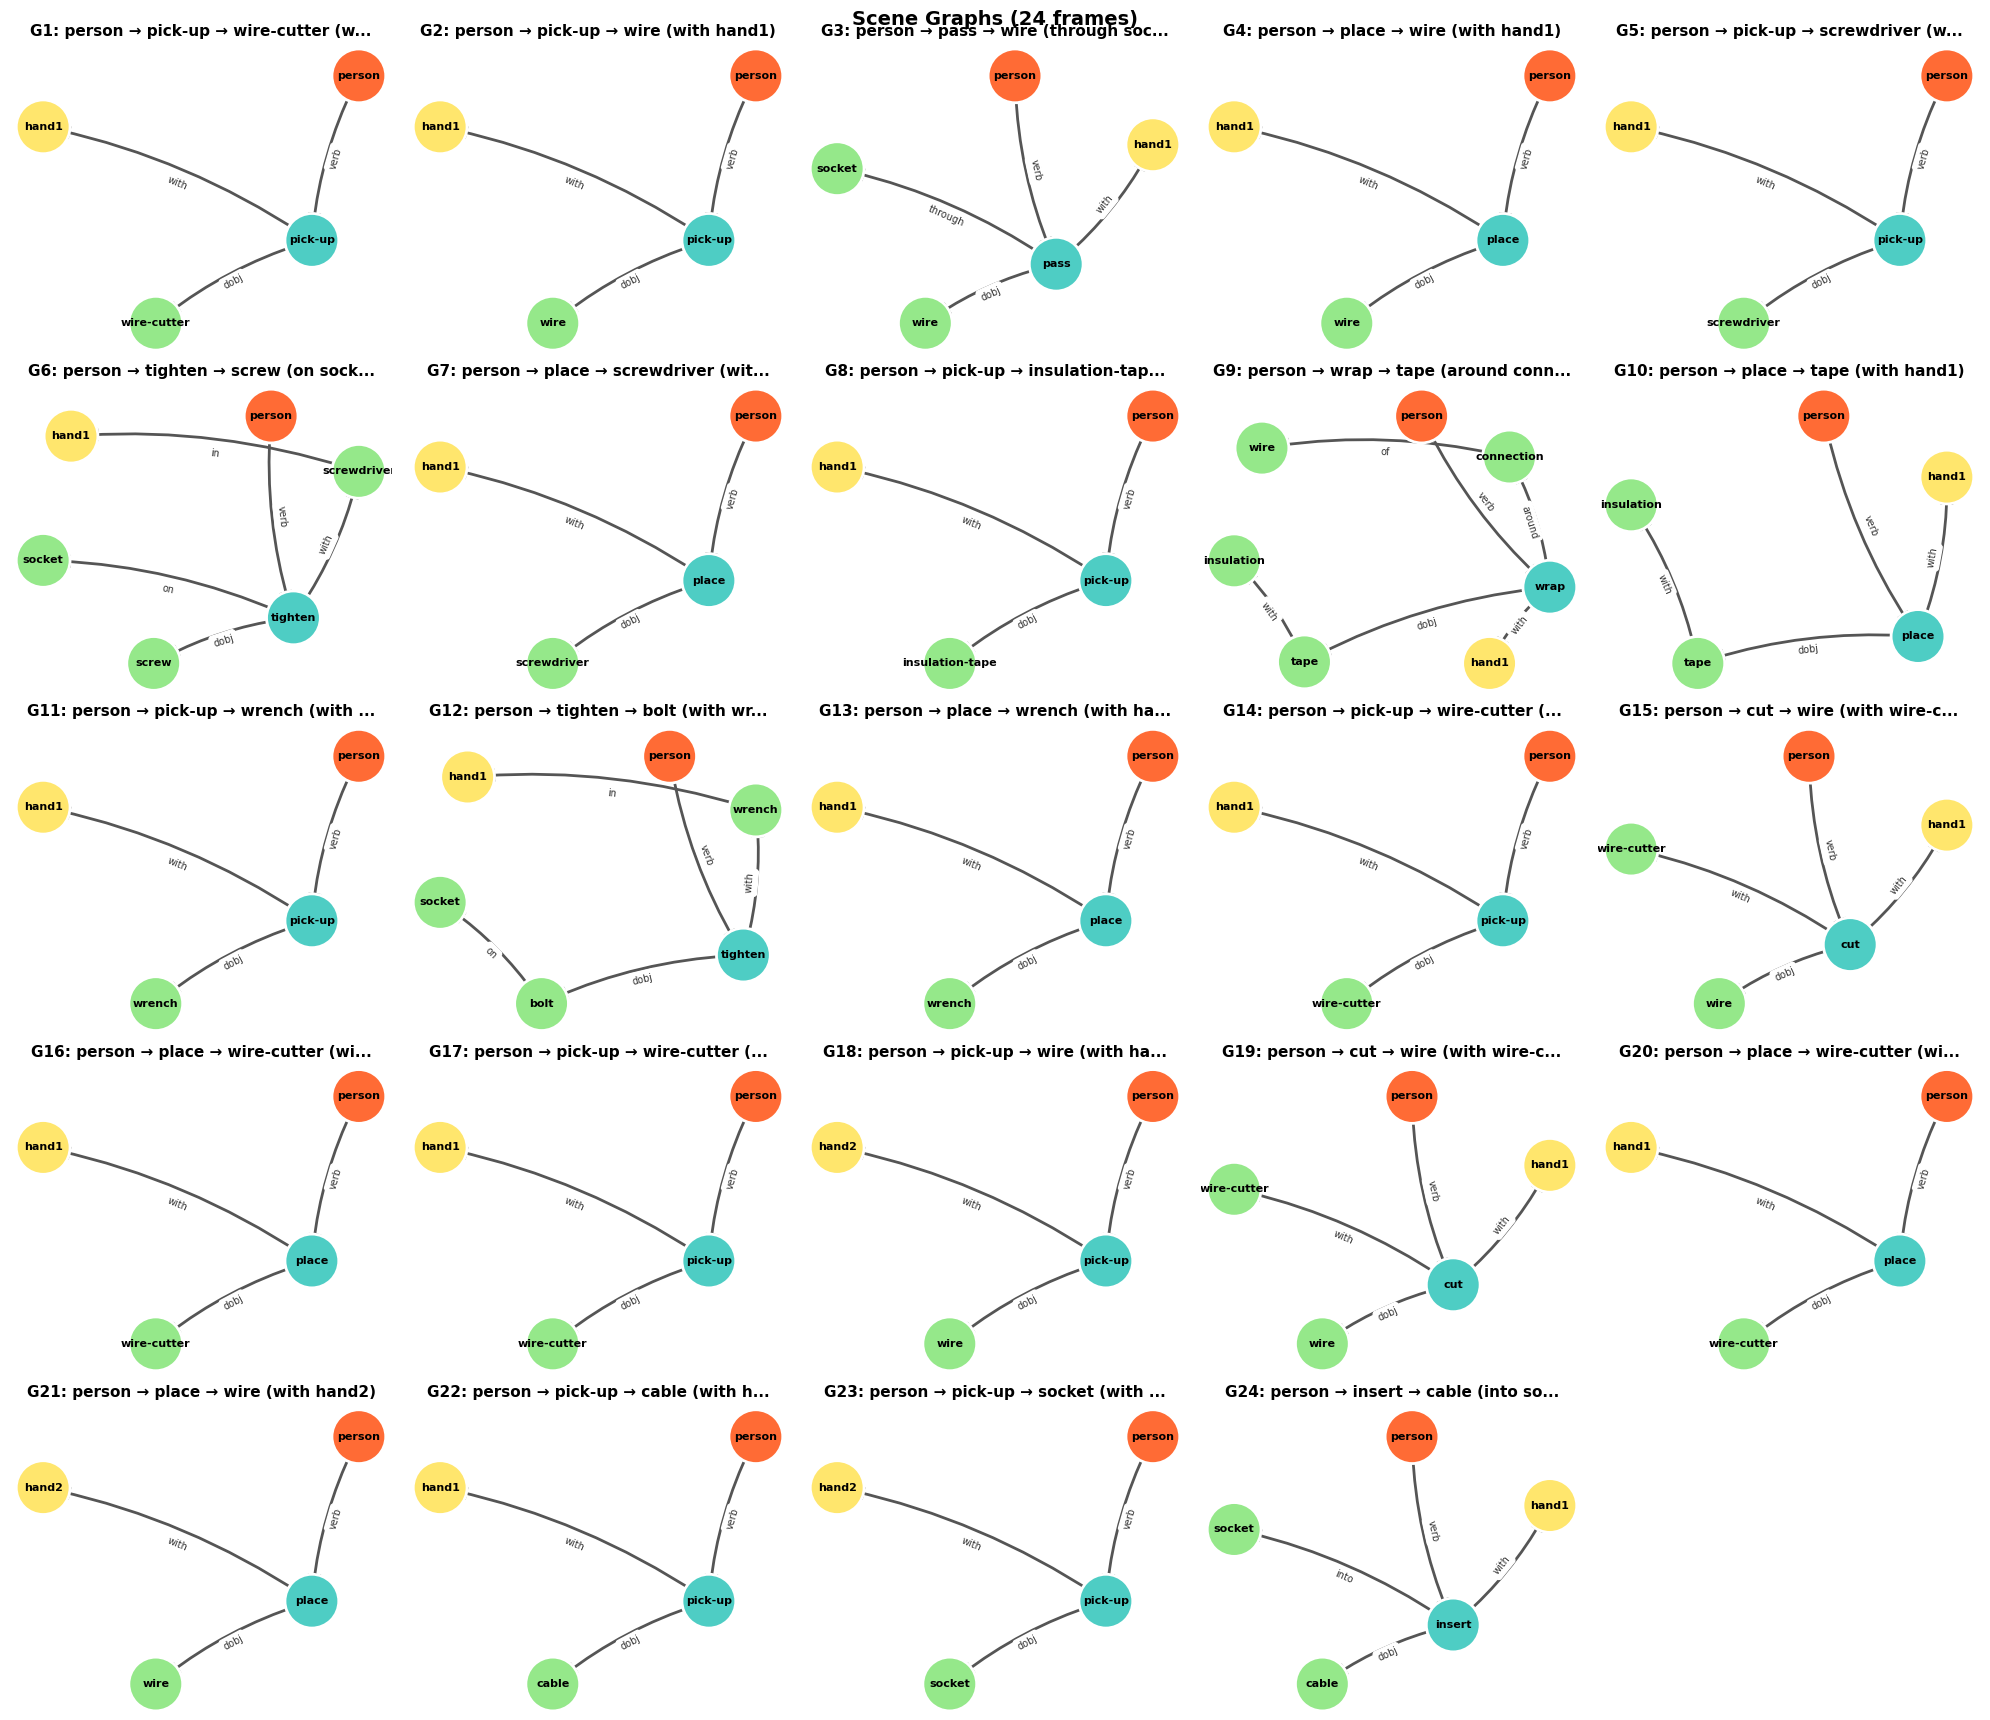

In [11]:
# Case 9
visualize_case(cases[8], 8)

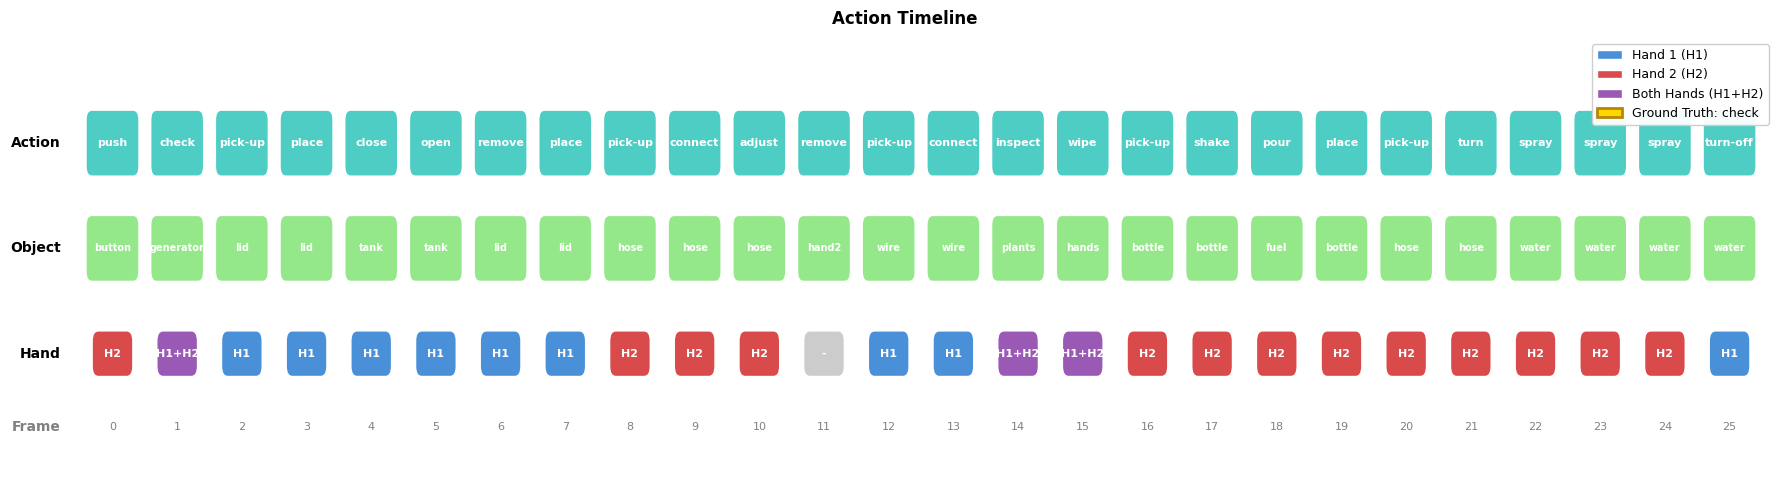

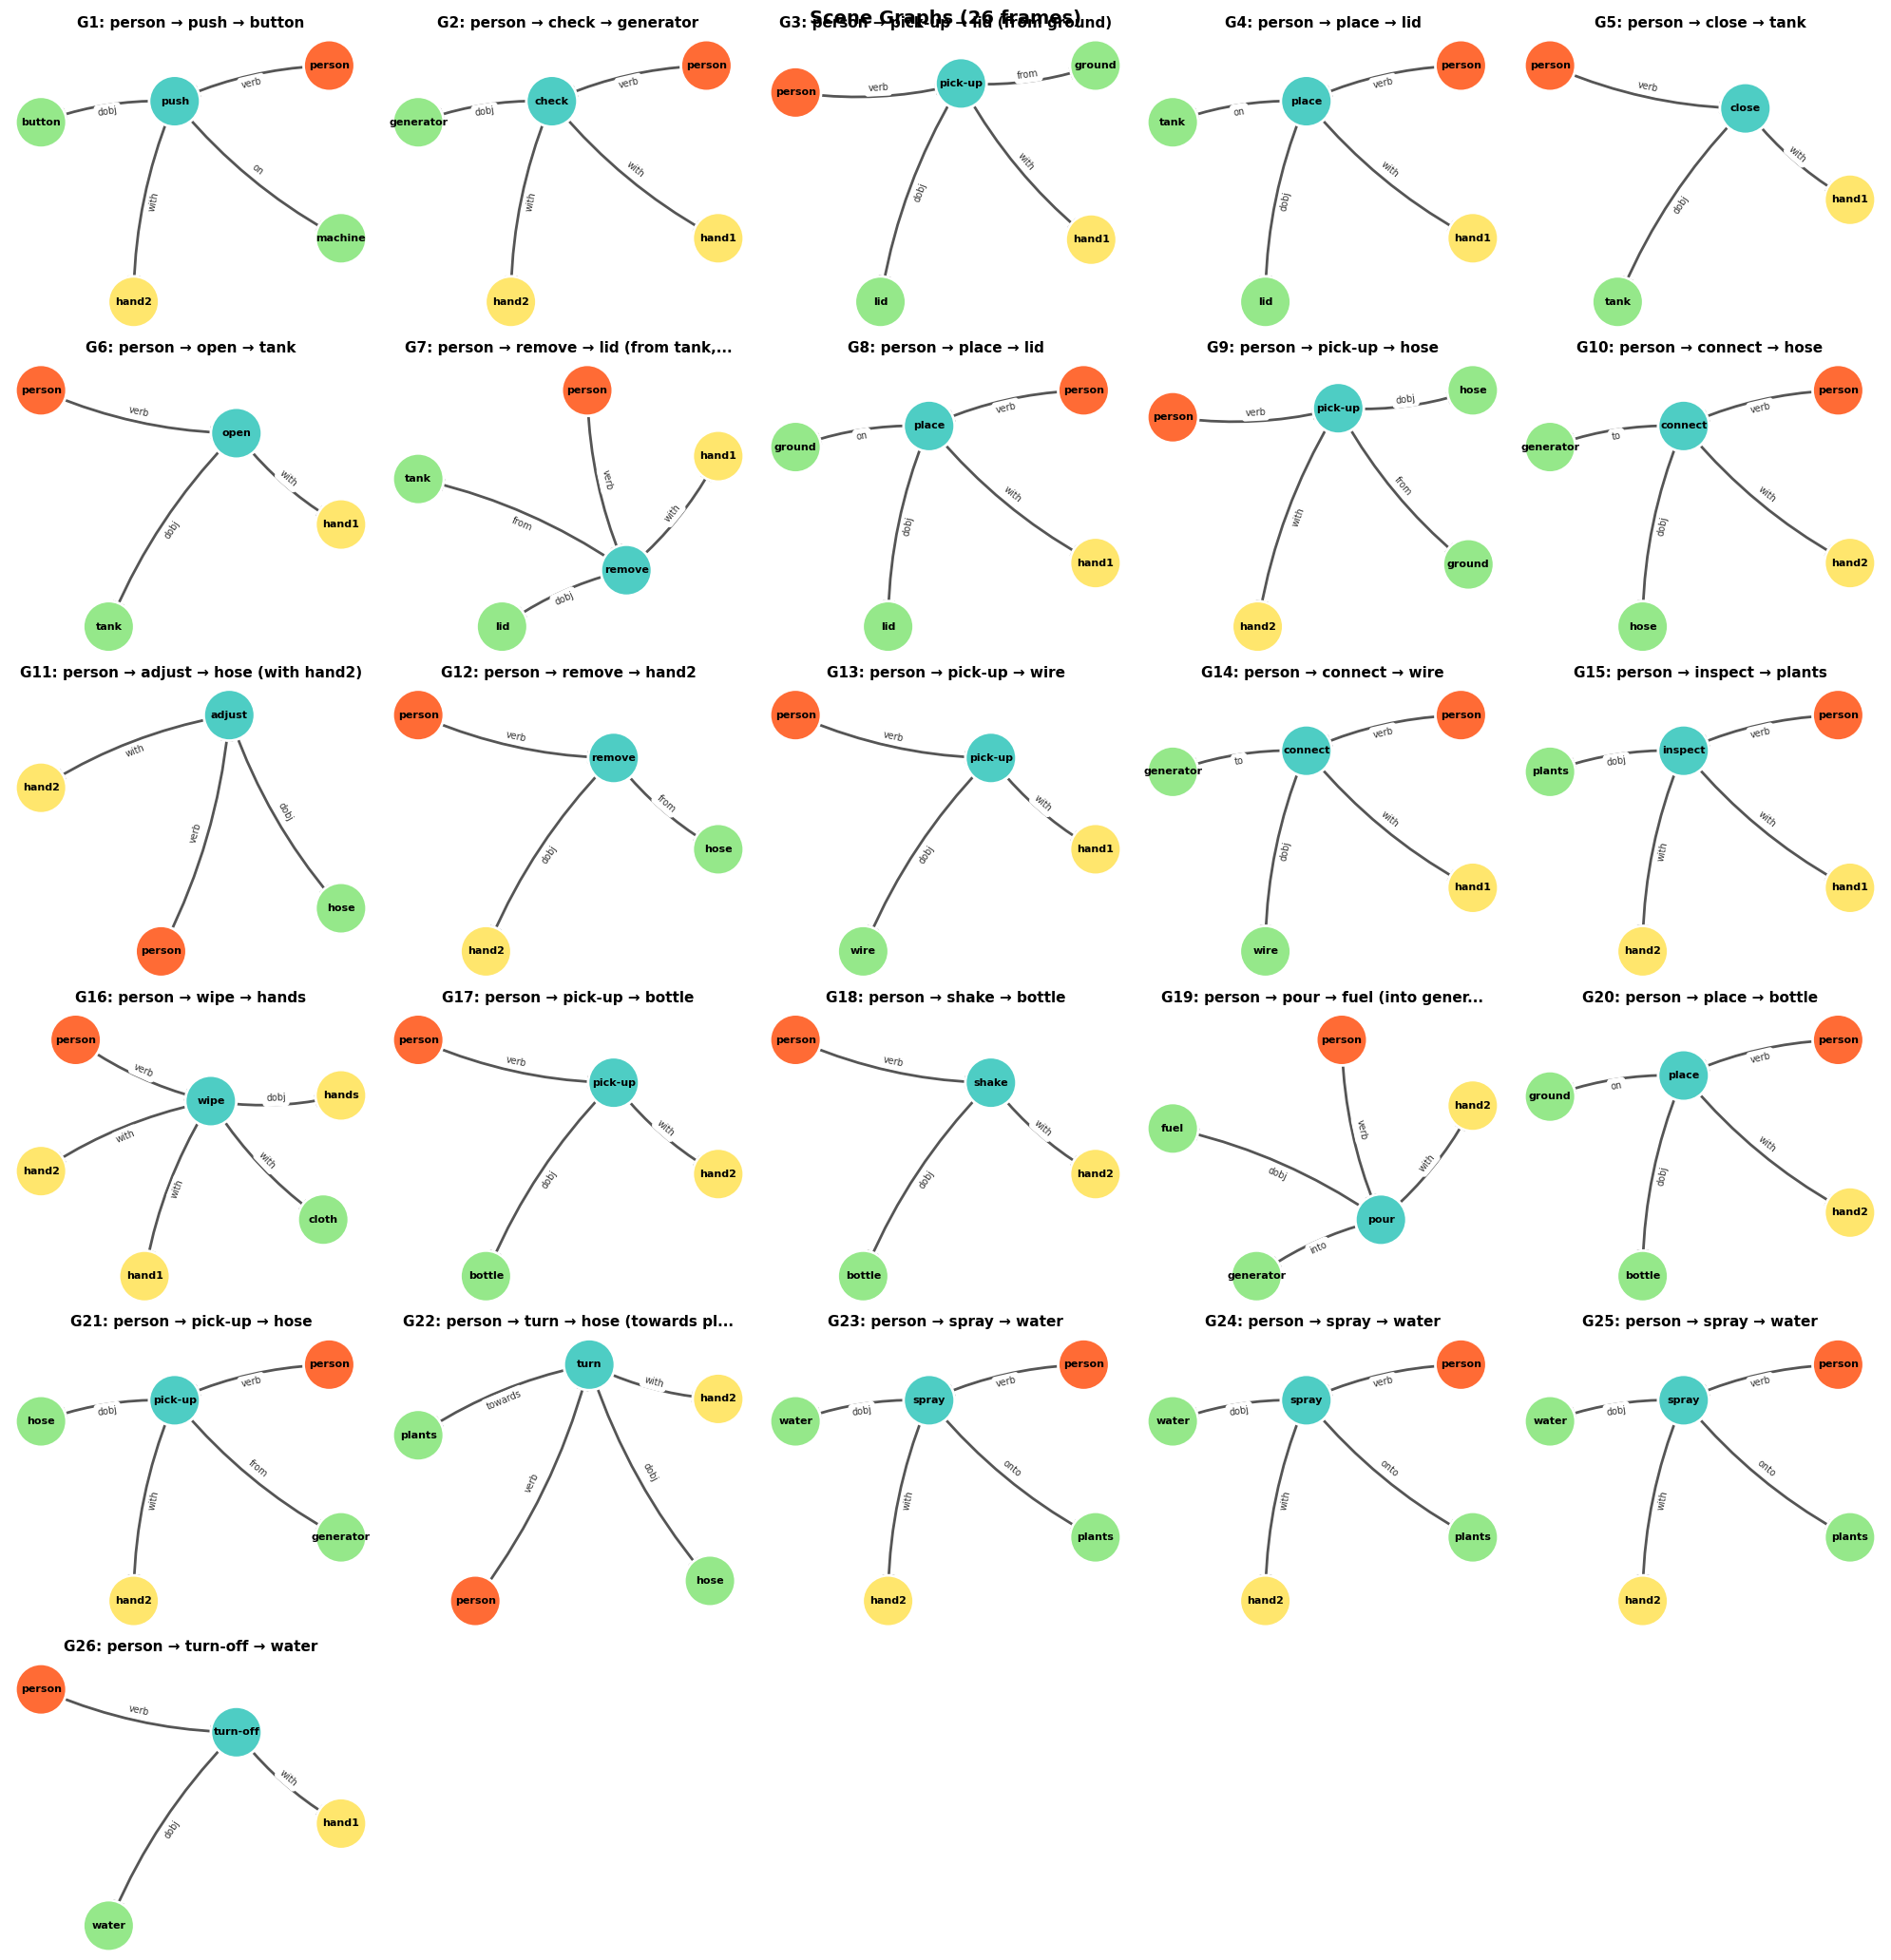

In [12]:
# Case 10
visualize_case(cases[9], 9)

---
## Summary Statistics

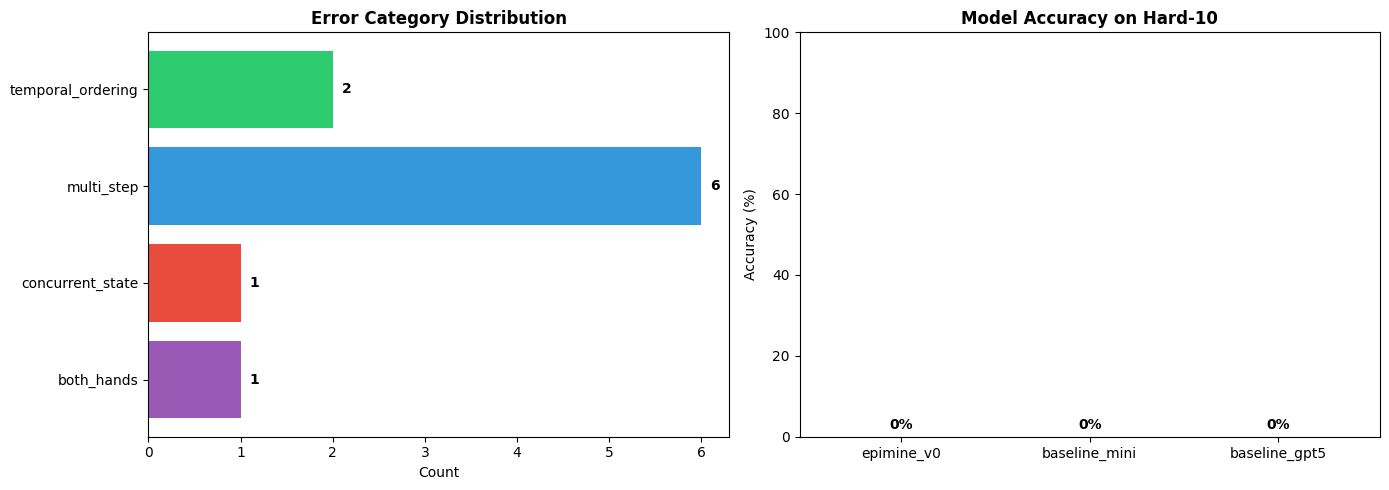


HARD-10 BENCHMARK SUMMARY

Total cases: 10

Error Categories:
  - both_hands: 1
  - concurrent_state: 1
  - multi_step: 6
  - temporal_ordering: 2

Model Performance:
  - epimine_v0: 0/10 (0.0%)
  - baseline_mini: 0/10 (0.0%)
  - baseline_gpt5: 0/10 (0.0%)


In [13]:
# Summary Statistics
from collections import Counter

# Error category distribution
error_cats = [c.get('error_category', 'unknown') for c in cases]
cat_counts = Counter(error_cats)

# Model accuracy
model_accuracy = {}
for case in cases:
    gt = case['ground_truth'].lower().strip()
    for model, pred_info in case.get('predictions', {}).items():
        if model not in model_accuracy:
            model_accuracy[model] = {'correct': 0, 'total': 0}
        model_accuracy[model]['total'] += 1
        # Handle nested dict format: {'answer': 'string', 'correct': bool}
        if isinstance(pred_info, dict):
            is_correct = pred_info.get('correct', False)
        else:
            is_correct = str(pred_info).lower().strip() == gt
        if is_correct:
            model_accuracy[model]['correct'] += 1

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error categories
ax1 = axes[0]
cats = list(cat_counts.keys())
counts = list(cat_counts.values())
colors = ['#9B59B6', '#E74C3C', '#3498DB', '#2ECC71'][:len(cats)]
bars = ax1.barh(cats, counts, color=colors)
ax1.set_xlabel('Count')
ax1.set_title('Error Category Distribution', fontsize=12, fontweight='bold')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             str(count), va='center', fontweight='bold')

# Model accuracy
ax2 = axes[1]
models = list(model_accuracy.keys())
accuracies = [model_accuracy[m]['correct'] / model_accuracy[m]['total'] * 100 for m in models]
bars = ax2.bar(models, accuracies, color=['#3498DB', '#E74C3C', '#9B59B6'][:len(models)])
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Model Accuracy on Hard-10', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100)
for bar, acc in zip(bars, accuracies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{acc:.0f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("HARD-10 BENCHMARK SUMMARY")
print("="*60)
print(f"\nTotal cases: {len(cases)}")
print(f"\nError Categories:")
for cat, count in cat_counts.items():
    print(f"  - {cat}: {count}")
print(f"\nModel Performance:")
for model, stats in model_accuracy.items():
    acc = stats['correct'] / stats['total'] * 100
    print(f"  - {model}: {stats['correct']}/{stats['total']} ({acc:.1f}%)")
print("="*60)

---
## Interactive Case Selector

Use this cell to visualize a specific case by index.

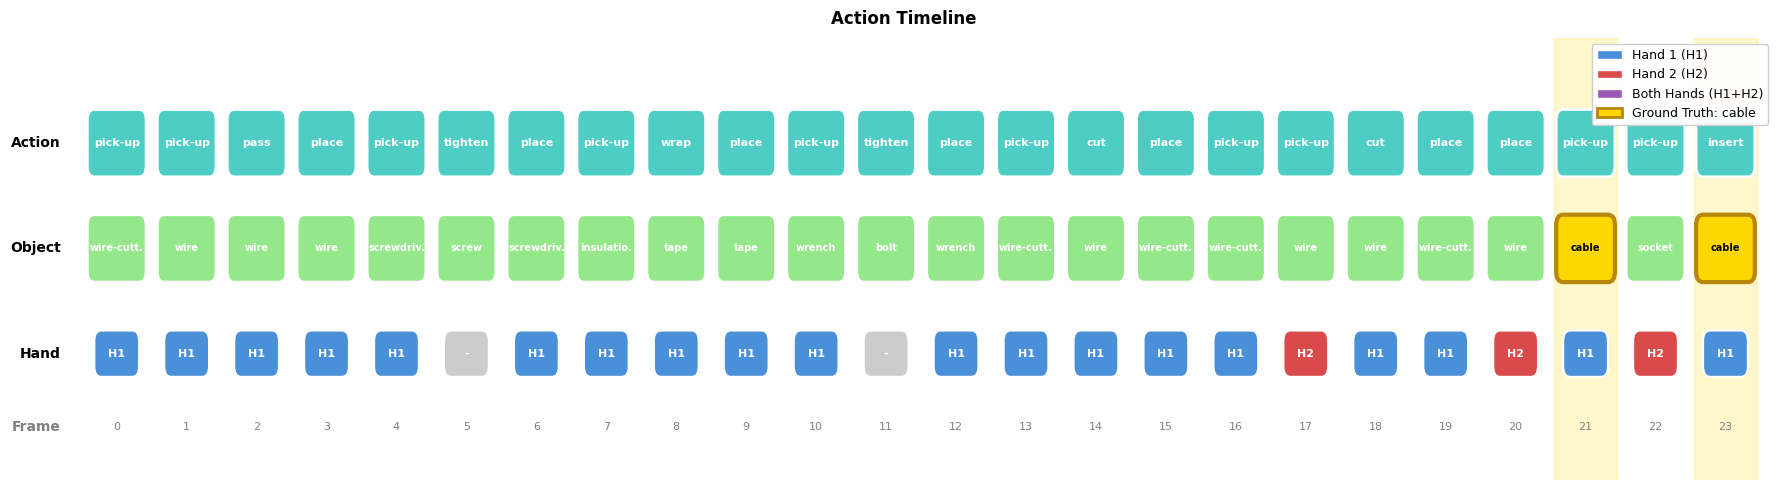

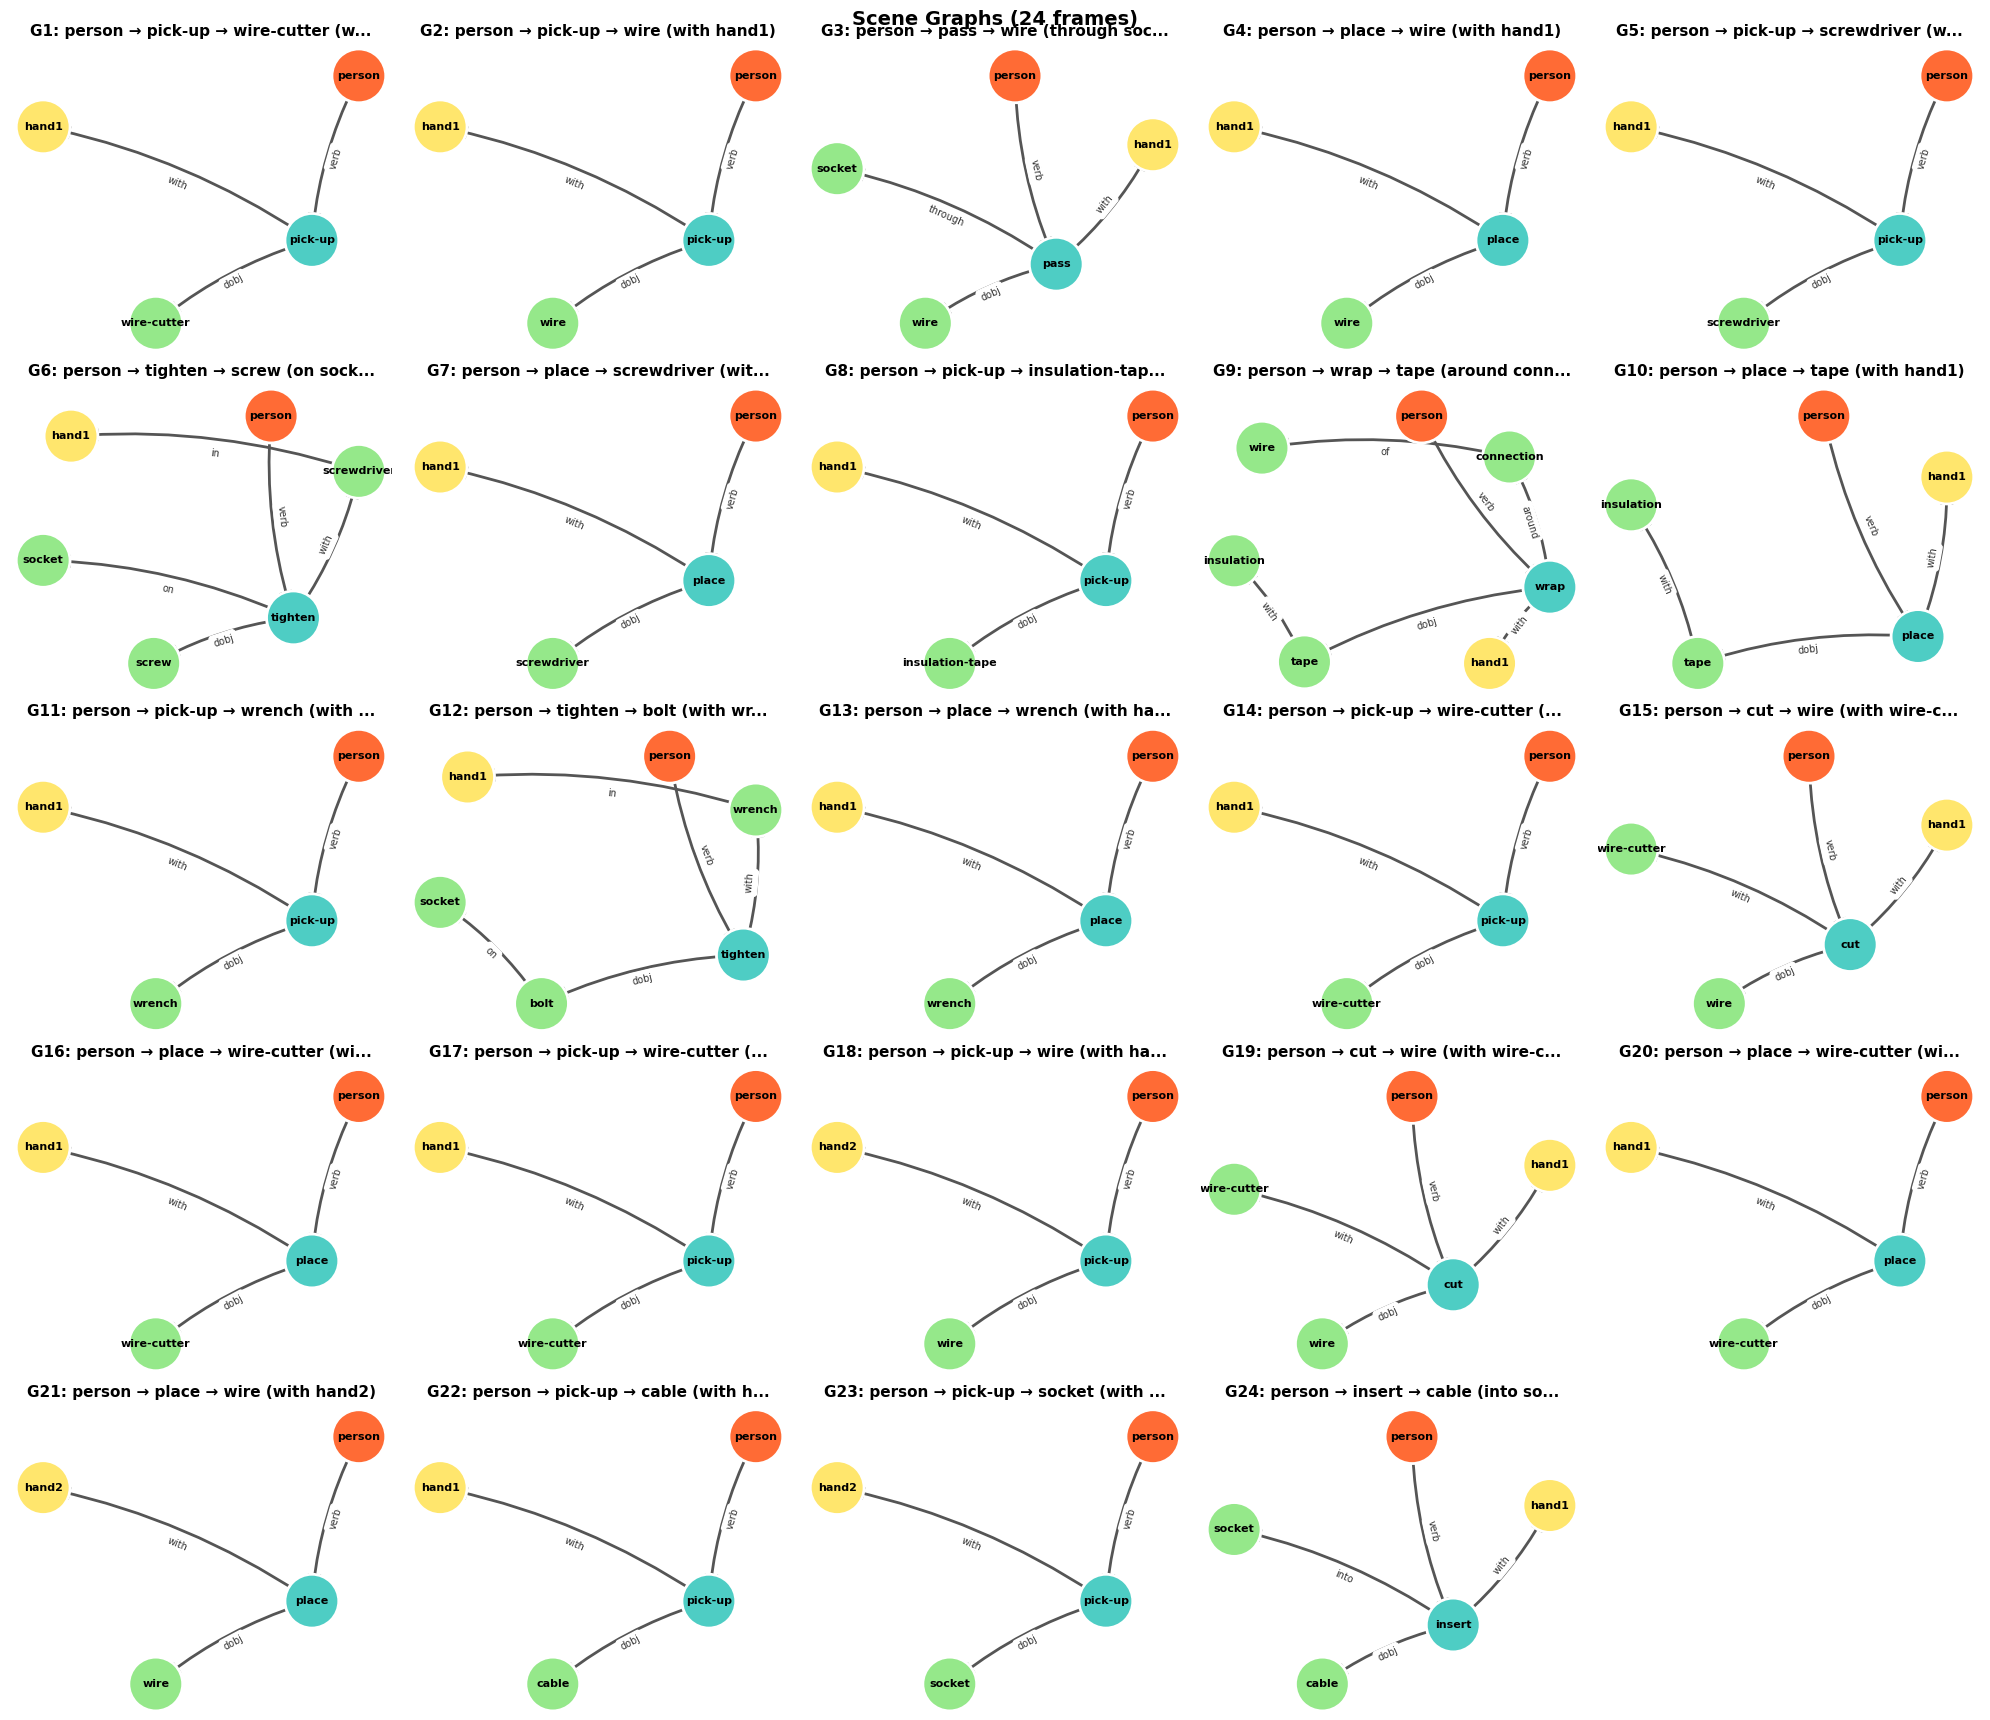

In [17]:
# Interactive case selector - change the index to view different cases
CASE_INDEX = 8  # Change this to 0-9

if 0 <= CASE_INDEX < len(cases):
    visualize_case(cases[CASE_INDEX], CASE_INDEX)
else:
    print(f"Invalid index. Please use 0-{len(cases)-1}")